In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})

#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  specific_humidity          slp  vapor_pressure  \
0      2006-01-31     6501           5.386935  1018.534543        8.674922   
1      2006-02-28     6501           4.299929  1021.230347        6.942276   
2      2006-03-31     6501           6.505135  1018.968548       10.468176   
3      2006-04-30     6501          10.211263  1014.686944       16.358802   
4      2006-05-31     6501          11.737971  1014.236828       18.798749   
...           ...      ...                ...          ...             ...   
24057  2024-07-31     9858          15.211417  1013.969355       23.769169   
24058  2024-08-31     9858          15.149811  1015.112097       23.699154   
24059  2024-09-30     9858          10.720199  1014.393750       16.790240   
24060  2024-10-31     9858           6.989922  1018.230376       10

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-18 23:01:59,148] A new study created in memory with name: no-name-c97a69de-9151-448a-9f42-2b6ba66afff2
[I 2025-05-18 23:08:30,829] Trial 0 finished with value: 0.260646590590477 and parameters: {'lr': 0.011255829435817922, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2164990048802897}. Best is trial 0 with value: 0.260646590590477.


Cross Validation Accuracies:
[0.3186092674732208, 0.21305261552333832, 0.26934441924095154, 0.2429727017879486, 0.25925394892692566]
Mean Cross Validation Accuracy:
0.260646590590477
Standard Deviation of Cross Validation Accuracy:
0.034683761023121464


[I 2025-05-18 23:15:00,842] Trial 1 finished with value: 0.025142764672636986 and parameters: {'lr': 0.022612232561305352, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.39595812786274354}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.018550125882029533, 0.023392533883452415, 0.029070742428302765, 0.033465392887592316, 0.0212350282818079]
Mean Cross Validation Accuracy:
0.025142764672636986
Standard Deviation of Cross Validation Accuracy:
0.0054127949784269005


[I 2025-05-18 23:22:24,090] Trial 2 finished with value: 0.1979050815105438 and parameters: {'lr': 0.05098833890286682, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22453896280760538}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.1544291228055954, 0.1728065311908722, 0.18827438354492188, 0.18283285200595856, 0.2911825180053711]
Mean Cross Validation Accuracy:
0.1979050815105438
Standard Deviation of Cross Validation Accuracy:
0.048043103184648536


[I 2025-05-18 23:27:00,861] Trial 3 finished with value: 0.44450308978557584 and parameters: {'lr': 0.023566645005813184, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4569727319367026}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.5547708868980408, 0.27656951546669006, 0.17526091635227203, 0.19954919815063477, 1.0163649320602417]
Mean Cross Validation Accuracy:
0.44450308978557584
Standard Deviation of Cross Validation Accuracy:
0.3161899416792125


[I 2025-05-18 23:32:43,451] Trial 4 finished with value: 0.07502672635018826 and parameters: {'lr': 0.001136039242891334, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3612875095359195}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.08822851628065109, 0.02351880632340908, 0.059556856751441956, 0.08483222872018814, 0.11899722367525101]
Mean Cross Validation Accuracy:
0.07502672635018826
Standard Deviation of Cross Validation Accuracy:
0.03192560871775756


[I 2025-05-18 23:37:10,263] Trial 5 finished with value: 0.16462933123111725 and parameters: {'lr': 0.2895169390961765, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1162910991266553}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.16126009821891785, 0.17139284312725067, 0.16537787020206451, 0.1627259999513626, 0.1623898446559906]
Mean Cross Validation Accuracy:
0.16462933123111725
Standard Deviation of Cross Validation Accuracy:
0.0036412938615641636


[I 2025-05-18 23:41:43,279] Trial 6 finished with value: 29.437032318115236 and parameters: {'lr': 0.2802109694832388, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17813875877057944}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[34.46468734741211, 26.384418487548828, 29.43224334716797, 30.687410354614258, 26.216402053833008]
Mean Cross Validation Accuracy:
29.437032318115236
Standard Deviation of Cross Validation Accuracy:
3.050629238691321


[I 2025-05-18 23:47:18,409] Trial 7 finished with value: 0.06934875696897506 and parameters: {'lr': 0.2914561769342426, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.10079189663741067}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.19700878858566284, 0.023245440796017647, 0.028583751991391182, 0.048047229647636414, 0.04985857382416725]
Mean Cross Validation Accuracy:
0.06934875696897506
Standard Deviation of Cross Validation Accuracy:
0.06468076587453139


[I 2025-05-18 23:53:55,089] Trial 8 finished with value: 30.011562156677247 and parameters: {'lr': 0.7715729748536286, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.332322198776169}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[55.987083435058594, 27.16429901123047, 13.522002220153809, 21.060829162597656, 32.3235969543457]
Mean Cross Validation Accuracy:
30.011562156677247
Standard Deviation of Cross Validation Accuracy:
14.423600979229809


[I 2025-05-18 23:59:48,244] Trial 9 finished with value: 0.20448897778987885 and parameters: {'lr': 0.011653851440074567, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.44154929756891914}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.22091640532016754, 0.18847419321537018, 0.19073118269443512, 0.2137928158044815, 0.20853029191493988]
Mean Cross Validation Accuracy:
0.20448897778987885
Standard Deviation of Cross Validation Accuracy:
0.012794563281162874


[I 2025-05-19 00:07:37,850] Trial 10 finished with value: 0.043905068561434744 and parameters: {'lr': 0.0020613911092474363, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.39184813331081436}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.03266017138957977, 0.09811132401227951, 0.03067469783127308, 0.036149464547634125, 0.021929685026407242]
Mean Cross Validation Accuracy:
0.043905068561434744
Standard Deviation of Cross Validation Accuracy:
0.027505910009289952


[I 2025-05-19 00:14:29,072] Trial 11 finished with value: 0.032165836170315744 and parameters: {'lr': 0.001121373779551643, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.41415783777231474}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.017880989238619804, 0.05635381117463112, 0.030641399323940277, 0.03587512671947479, 0.02007785439491272]
Mean Cross Validation Accuracy:
0.032165836170315744
Standard Deviation of Cross Validation Accuracy:
0.013793600212783549


[I 2025-05-19 00:20:56,727] Trial 12 finished with value: 0.07059540674090385 and parameters: {'lr': 0.003965036907083519, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4983496899330325}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.059522390365600586, 0.042736735194921494, 0.04276736080646515, 0.14503024518489838, 0.06292030215263367]
Mean Cross Validation Accuracy:
0.07059540674090385
Standard Deviation of Cross Validation Accuracy:
0.03813809071547327


[I 2025-05-19 00:27:43,614] Trial 13 finished with value: 0.02555919736623764 and parameters: {'lr': 0.07475837895076476, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29840194271765497}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.018451711162924767, 0.025250129401683807, 0.031240535899996758, 0.033345311880111694, 0.019508298486471176]
Mean Cross Validation Accuracy:
0.02555919736623764
Standard Deviation of Cross Validation Accuracy:
0.00600210708249181


[I 2025-05-19 00:34:51,390] Trial 14 finished with value: 0.03436440005898476 and parameters: {'lr': 0.06878759402977924, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.27612090227840963}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.020489253103733063, 0.024504639208316803, 0.059502486139535904, 0.03360266610980034, 0.033722955733537674]
Mean Cross Validation Accuracy:
0.03436440005898476
Standard Deviation of Cross Validation Accuracy:
0.01358417938844583


[I 2025-05-19 00:41:48,503] Trial 15 finished with value: 0.02825528122484684 and parameters: {'lr': 0.10756944443014584, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2932949179374239}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.017914749681949615, 0.023259403184056282, 0.030291147530078888, 0.03364859148859978, 0.03616251423954964]
Mean Cross Validation Accuracy:
0.02825528122484684
Standard Deviation of Cross Validation Accuracy:
0.006747477619833853


[I 2025-05-19 00:45:36,576] Trial 16 finished with value: 0.025898560136556625 and parameters: {'lr': 0.018202112618384513, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.32442672614828105}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.017856670543551445, 0.02453780360519886, 0.029386429116129875, 0.03644876182079315, 0.021263135597109795]
Mean Cross Validation Accuracy:
0.025898560136556625
Standard Deviation of Cross Validation Accuracy:
0.006503580441900605


[I 2025-05-19 00:51:40,193] Trial 17 finished with value: 0.026444927603006364 and parameters: {'lr': 0.12672180423198406, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2542803702262858}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.021200697869062424, 0.028322191908955574, 0.029270373284816742, 0.03370251506567001, 0.01972885988652706]
Mean Cross Validation Accuracy:
0.026444927603006364
Standard Deviation of Cross Validation Accuracy:
0.0052304369115434655


[I 2025-05-19 00:58:37,088] Trial 18 finished with value: 0.05596708506345749 and parameters: {'lr': 0.005141440342613256, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3766101406875844}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.06393802165985107, 0.09502366185188293, 0.04812813177704811, 0.03461727127432823, 0.038128338754177094]
Mean Cross Validation Accuracy:
0.05596708506345749
Standard Deviation of Cross Validation Accuracy:
0.022020157256467388


[I 2025-05-19 01:01:59,945] Trial 19 finished with value: 0.028785350918769836 and parameters: {'lr': 0.042343741892757115, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3380445901976409}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.030872352421283722, 0.02425040490925312, 0.033078040927648544, 0.03485102578997612, 0.020874930545687675]
Mean Cross Validation Accuracy:
0.028785350918769836
Standard Deviation of Cross Validation Accuracy:
0.005342577284702778


[I 2025-05-19 01:07:26,840] Trial 20 finished with value: 0.034830210730433464 and parameters: {'lr': 0.008452075043933622, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4984144498748896}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.017863264307379723, 0.030507875606417656, 0.058888029307127, 0.03988875821232796, 0.027003126218914986]
Mean Cross Validation Accuracy:
0.034830210730433464
Standard Deviation of Cross Validation Accuracy:
0.013944107293715228


[I 2025-05-19 01:11:13,438] Trial 21 finished with value: 0.025695379078388213 and parameters: {'lr': 0.020870601023963833, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.32236598109412523}. Best is trial 1 with value: 0.025142764672636986.


Cross Validation Accuracies:
[0.01867479272186756, 0.02423745207488537, 0.030670899897813797, 0.033435944467782974, 0.02145780622959137]
Mean Cross Validation Accuracy:
0.025695379078388213
Standard Deviation of Cross Validation Accuracy:
0.005550556144348067


[I 2025-05-19 01:15:21,734] Trial 22 finished with value: 0.024759716168046 and parameters: {'lr': 0.03030706148672675, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3157642916101342}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.01784280501306057, 0.02373163215816021, 0.029686326161026955, 0.03332009166479111, 0.019217725843191147]
Mean Cross Validation Accuracy:
0.024759716168046
Standard Deviation of Cross Validation Accuracy:
0.005952575712854787


[I 2025-05-19 01:19:35,421] Trial 23 finished with value: 0.02553347758948803 and parameters: {'lr': 0.09253057240976699, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26215393571436885}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018186338245868683, 0.02816779725253582, 0.02870103530585766, 0.03353766351938248, 0.01907455362379551]
Mean Cross Validation Accuracy:
0.02553347758948803
Standard Deviation of Cross Validation Accuracy:
0.005945388291829723


[I 2025-05-19 01:23:49,044] Trial 24 finished with value: 0.024987100437283517 and parameters: {'lr': 0.03063278134693428, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.247425874235641}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.01848645508289337, 0.02335241250693798, 0.029840392991900444, 0.03324177488684654, 0.02001446671783924]
Mean Cross Validation Accuracy:
0.024987100437283517
Standard Deviation of Cross Validation Accuracy:
0.0056807003027777225


[I 2025-05-19 01:28:19,581] Trial 25 finished with value: 0.02531408183276653 and parameters: {'lr': 0.030249288393688407, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.161177877989862}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.019738314673304558, 0.02439005859196186, 0.029494555667042732, 0.03376511111855507, 0.019182369112968445]
Mean Cross Validation Accuracy:
0.02531408183276653
Standard Deviation of Cross Validation Accuracy:
0.0056291590262229916


[I 2025-05-19 01:33:21,453] Trial 26 finished with value: 0.02511996142566204 and parameters: {'lr': 0.014280095161188978, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.22338303097506243}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.019365226849913597, 0.023339511826634407, 0.02860146015882492, 0.035275816917419434, 0.019017791375517845]
Mean Cross Validation Accuracy:
0.02511996142566204
Standard Deviation of Cross Validation Accuracy:
0.006144683626214495


[I 2025-05-19 01:37:37,587] Trial 27 finished with value: 0.040371468663215636 and parameters: {'lr': 0.004656764854869604, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21476082733298477}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.03145083412528038, 0.03683500736951828, 0.059093985706567764, 0.03846330568194389, 0.03601421043276787]
Mean Cross Validation Accuracy:
0.040371468663215636
Standard Deviation of Cross Validation Accuracy:
0.009646177571761103


[I 2025-05-19 01:41:42,283] Trial 28 finished with value: 0.0419940073043108 and parameters: {'lr': 0.00804184402663589, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.17336808953326857}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.05006880685687065, 0.027685804292559624, 0.038789309561252594, 0.05414445325732231, 0.03928166255354881]
Mean Cross Validation Accuracy:
0.0419940073043108
Standard Deviation of Cross Validation Accuracy:
0.009329386901269648


[I 2025-05-19 01:46:35,651] Trial 29 finished with value: 0.2335130862891674 and parameters: {'lr': 0.01261139134327972, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22526900942893552}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.24030572175979614, 0.17592281103134155, 0.05095144733786583, 0.3421632647514343, 0.35822218656539917]
Mean Cross Validation Accuracy:
0.2335130862891674
Standard Deviation of Cross Validation Accuracy:
0.11318016848289639


[I 2025-05-19 01:51:58,509] Trial 30 finished with value: 1.548664426803589 and parameters: {'lr': 0.0391924857324234, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23716454219554278}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[1.0709303617477417, 1.834434151649475, 1.4587398767471313, 1.4939497709274292, 1.885267972946167]
Mean Cross Validation Accuracy:
1.548664426803589
Standard Deviation of Cross Validation Accuracy:
0.29471214365870285


[I 2025-05-19 01:56:31,325] Trial 31 finished with value: 0.026657195389270784 and parameters: {'lr': 0.015121608291937934, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2017792696255501}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.024730218574404716, 0.024503068998456, 0.02895205095410347, 0.03349235653877258, 0.02160828188061714]
Mean Cross Validation Accuracy:
0.026657195389270784
Standard Deviation of Cross Validation Accuracy:
0.004143206916715689


[I 2025-05-19 02:01:01,843] Trial 32 finished with value: 0.049388312920928004 and parameters: {'lr': 0.02874784831696214, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2823951019626971}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.019420383498072624, 0.024751214310526848, 0.15003342926502228, 0.03344070538878441, 0.01929583214223385]
Mean Cross Validation Accuracy:
0.049388312920928004
Standard Deviation of Cross Validation Accuracy:
0.05058534659595307


[I 2025-05-19 02:05:04,315] Trial 33 finished with value: 0.02533617615699768 and parameters: {'lr': 0.0514461025521305, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.25271349814426997}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017927026376128197, 0.024722926318645477, 0.030687682330608368, 0.03405774012207985, 0.019285505637526512]
Mean Cross Validation Accuracy:
0.02533617615699768
Standard Deviation of Cross Validation Accuracy:
0.006270350642476191


[I 2025-05-19 02:10:03,937] Trial 34 finished with value: 0.0377363383769989 and parameters: {'lr': 0.007871029843867117, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20274718284019716}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017886629328131676, 0.0501028411090374, 0.03691064566373825, 0.05853456258773804, 0.025247013196349144]
Mean Cross Validation Accuracy:
0.0377363383769989
Standard Deviation of Cross Validation Accuracy:
0.015074299196918684


[I 2025-05-19 02:14:32,704] Trial 35 finished with value: 3.7965720295906067 and parameters: {'lr': 0.17264006394424228, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.35664147237787336}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[5.199728012084961, 6.200915813446045, 6.991169452667236, 0.36647388339042664, 0.22457298636436462]
Mean Cross Validation Accuracy:
3.7965720295906067
Standard Deviation of Cross Validation Accuracy:
2.9147870898258392


[I 2025-05-19 02:18:38,660] Trial 36 finished with value: 0.11910889595746994 and parameters: {'lr': 0.025220347010624387, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4124891187933379}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.17188102006912231, 0.0782228633761406, 0.1837964653968811, 0.08816725760698318, 0.0734768733382225]
Mean Cross Validation Accuracy:
0.11910889595746994
Standard Deviation of Cross Validation Accuracy:
0.04833365878062953


[I 2025-05-19 02:23:34,103] Trial 37 finished with value: 0.026387744769454 and parameters: {'lr': 0.055714844710120955, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.44600779047535083}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.021751243621110916, 0.02324856072664261, 0.028986316174268723, 0.033528272062540054, 0.02442433126270771]
Mean Cross Validation Accuracy:
0.026387744769454
Standard Deviation of Cross Validation Accuracy:
0.004311526767188852


[I 2025-05-19 02:27:58,650] Trial 38 finished with value: 1.0888853549957276 and parameters: {'lr': 0.018423348399193178, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1276174139752926}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[1.717370867729187, 0.6422958374023438, 0.6316299438476562, 1.016416072845459, 1.4367140531539917]
Mean Cross Validation Accuracy:
1.0888853549957276
Standard Deviation of Cross Validation Accuracy:
0.43122044202059123


[I 2025-05-19 02:33:10,334] Trial 39 finished with value: 0.02901853881776333 and parameters: {'lr': 0.0028377378771832088, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15025223700485058}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.02160649187862873, 0.026437275111675262, 0.03062671236693859, 0.0474262498319149, 0.018995964899659157]
Mean Cross Validation Accuracy:
0.02901853881776333
Standard Deviation of Cross Validation Accuracy:
0.010034773510517795


[I 2025-05-19 02:37:59,419] Trial 40 finished with value: 0.08219647854566574 and parameters: {'lr': 0.03352775454785791, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31110348642928226}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.09925158321857452, 0.10450173169374466, 0.09096033126115799, 0.06481028348207474, 0.051458463072776794]
Mean Cross Validation Accuracy:
0.08219647854566574
Standard Deviation of Cross Validation Accuracy:
0.020553887232459933


[I 2025-05-19 02:42:46,106] Trial 41 finished with value: 0.025465866550803185 and parameters: {'lr': 0.026819948237058296, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1662837809123007}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018238333985209465, 0.025664551183581352, 0.028809307143092155, 0.033409569412469864, 0.021207571029663086]
Mean Cross Validation Accuracy:
0.025465866550803185
Standard Deviation of Cross Validation Accuracy:
0.005379419921590036


[I 2025-05-19 02:47:46,874] Trial 42 finished with value: 0.037049407884478566 and parameters: {'lr': 0.011253199972304182, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.13822239554560584}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.043387994170188904, 0.04745922237634659, 0.03375867009162903, 0.03402301296591759, 0.026618139818310738]
Mean Cross Validation Accuracy:
0.037049407884478566
Standard Deviation of Cross Validation Accuracy:
0.007447701507836271


[I 2025-05-19 02:52:26,879] Trial 43 finished with value: 0.025792376697063447 and parameters: {'lr': 0.03421594885224955, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1934125898724051}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.01787942461669445, 0.02809261530637741, 0.028955167159438133, 0.034789059311151505, 0.01924561709165573]
Mean Cross Validation Accuracy:
0.025792376697063447
Standard Deviation of Cross Validation Accuracy:
0.0063515275514558775


[I 2025-05-19 02:56:47,719] Trial 44 finished with value: 0.18848670944571494 and parameters: {'lr': 0.971230810580284, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23511379704930244}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.04340953007340431, 0.48065587878227234, 0.21572373807430267, 0.06740414351224899, 0.13524025678634644]
Mean Cross Validation Accuracy:
0.18848670944571494
Standard Deviation of Cross Validation Accuracy:
0.15789125353089864


[I 2025-05-19 03:00:59,514] Trial 45 finished with value: 0.02708139792084694 and parameters: {'lr': 0.014213839748738334, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.15282542882307618}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017857221886515617, 0.029924653470516205, 0.03026522882282734, 0.03316420689225197, 0.024195678532123566]
Mean Cross Validation Accuracy:
0.02708139792084694
Standard Deviation of Cross Validation Accuracy:
0.005452233417940253


[I 2025-05-19 03:07:05,932] Trial 46 finished with value: 0.02485563009977341 and parameters: {'lr': 0.04645083649147175, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10266490880003884}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.019224710762500763, 0.023243315517902374, 0.02900543250143528, 0.0332445353269577, 0.019560156390070915]
Mean Cross Validation Accuracy:
0.02485563009977341
Standard Deviation of Cross Validation Accuracy:
0.005476192903604727


[I 2025-05-19 03:12:47,524] Trial 47 finished with value: 0.046608734875917435 and parameters: {'lr': 0.06251676120291397, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10444335731891005}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.04625608026981354, 0.047724343836307526, 0.042510129511356354, 0.055997833609580994, 0.04055528715252876]
Mean Cross Validation Accuracy:
0.046608734875917435
Standard Deviation of Cross Validation Accuracy:
0.0053472781661028255


[I 2025-05-19 03:18:56,149] Trial 48 finished with value: 0.037769871205091475 and parameters: {'lr': 0.19722509279701197, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.47184738492092043}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.03433569148182869, 0.05821290984749794, 0.032769884914159775, 0.03446628153324127, 0.029064588248729706]
Mean Cross Validation Accuracy:
0.037769871205091475
Standard Deviation of Cross Validation Accuracy:
0.010405834308563405


[I 2025-05-19 03:24:55,011] Trial 49 finished with value: 0.025667911022901536 and parameters: {'lr': 0.042146097647659975, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35192741264672034}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.019162431359291077, 0.02428591437637806, 0.02970867045223713, 0.03354606777429581, 0.021636471152305603]
Mean Cross Validation Accuracy:
0.025667911022901536
Standard Deviation of Cross Validation Accuracy:
0.005270232981191355


[I 2025-05-19 03:32:56,656] Trial 50 finished with value: 0.7953653365373612 and parameters: {'lr': 0.4199950891624185, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.40850305916723834}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.21333672106266022, 0.20294031500816345, 0.21878504753112793, 3.1352286338806152, 0.2065359652042389]
Mean Cross Validation Accuracy:
0.7953653365373612
Standard Deviation of Cross Validation Accuracy:
1.1699444280677938


[I 2025-05-19 03:39:29,066] Trial 51 finished with value: 0.0263177789747715 and parameters: {'lr': 0.022071012240299122, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.11383870158764832}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018003040924668312, 0.024984581395983696, 0.028760822489857674, 0.0339350625872612, 0.025905387476086617]
Mean Cross Validation Accuracy:
0.0263177789747715
Standard Deviation of Cross Validation Accuracy:
0.005197572945593275


[I 2025-05-19 03:45:05,215] Trial 52 finished with value: 0.025138881430029868 and parameters: {'lr': 0.08108693973711033, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1918910067783679}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018933722749352455, 0.023563403636217117, 0.0293048694729805, 0.03316386789083481, 0.020728543400764465]
Mean Cross Validation Accuracy:
0.025138881430029868
Standard Deviation of Cross Validation Accuracy:
0.005332786703660258


[I 2025-05-19 03:50:34,618] Trial 53 finished with value: 0.026626985520124435 and parameters: {'lr': 0.0788843344058899, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2655162044210173}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018690507858991623, 0.030619926750659943, 0.029892785474658012, 0.033696096390485764, 0.020235611125826836]
Mean Cross Validation Accuracy:
0.026626985520124435
Standard Deviation of Cross Validation Accuracy:
0.006006974310328717


[I 2025-05-19 03:56:00,888] Trial 54 finished with value: 0.025079502165317534 and parameters: {'lr': 0.045337939017587696, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1866050251908918}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017850635573267937, 0.026263155043125153, 0.02878616936504841, 0.033180661499500275, 0.019316889345645905]
Mean Cross Validation Accuracy:
0.025079502165317534
Standard Deviation of Cross Validation Accuracy:
0.005765993706857712


[I 2025-05-19 04:02:36,358] Trial 55 finished with value: 0.028605865314602852 and parameters: {'lr': 0.1259705231589605, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.17836802185483847}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017986305058002472, 0.023814605548977852, 0.03476140275597572, 0.03505930304527283, 0.031407710164785385]
Mean Cross Validation Accuracy:
0.028605865314602852
Standard Deviation of Cross Validation Accuracy:
0.00668010575493436


[I 2025-05-19 04:08:33,663] Trial 56 finished with value: 0.02523961253464222 and parameters: {'lr': 0.08773603155283027, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22030355429237464}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018637409433722496, 0.023634398356080055, 0.028925050050020218, 0.033172961324453354, 0.021828243508934975]
Mean Cross Validation Accuracy:
0.02523961253464222
Standard Deviation of Cross Validation Accuracy:
0.005183120868259955


[I 2025-05-19 04:14:21,835] Trial 57 finished with value: 0.02543265074491501 and parameters: {'lr': 0.04756819114709104, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.186252351658923}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.01799088716506958, 0.024386102333664894, 0.029117660596966743, 0.034429267048835754, 0.02123933658003807]
Mean Cross Validation Accuracy:
0.02543265074491501
Standard Deviation of Cross Validation Accuracy:
0.00580650316404723


[I 2025-05-19 04:19:52,102] Trial 58 finished with value: 0.02639761343598366 and parameters: {'lr': 0.07066399179492754, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24444492699773818}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017878195270895958, 0.03243357688188553, 0.02941838651895523, 0.0332268662750721, 0.019031042233109474]
Mean Cross Validation Accuracy:
0.02639761343598366
Standard Deviation of Cross Validation Accuracy:
0.006618813734165786


[I 2025-05-19 04:23:37,838] Trial 59 finished with value: 0.07039393559098243 and parameters: {'lr': 0.1450825986069326, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.28107271632102937}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.07139714807271957, 0.08214316517114639, 0.06475234031677246, 0.0716579481959343, 0.06201907619833946]
Mean Cross Validation Accuracy:
0.07039393559098243
Standard Deviation of Cross Validation Accuracy:
0.006965837005858215


[I 2025-05-19 04:28:53,860] Trial 60 finished with value: 0.039948853105306624 and parameters: {'lr': 0.009798864329082509, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2118590491023617}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.03265811502933502, 0.05288233980536461, 0.037329696118831635, 0.056002177298069, 0.02087193727493286]
Mean Cross Validation Accuracy:
0.039948853105306624
Standard Deviation of Cross Validation Accuracy:
0.01303017926561177


[I 2025-05-19 04:34:11,448] Trial 61 finished with value: 0.027566833794116972 and parameters: {'lr': 0.018107440010080154, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.13801379045012133}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.023194218054413795, 0.029260791838169098, 0.02905932627618313, 0.034158919006586075, 0.022160913795232773]
Mean Cross Validation Accuracy:
0.027566833794116972
Standard Deviation of Cross Validation Accuracy:
0.004402189331546812


[I 2025-05-19 04:39:32,610] Trial 62 finished with value: 0.04354890063405037 and parameters: {'lr': 0.006275192633288592, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3862109270022674}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.03219371289014816, 0.034758441150188446, 0.07642622292041779, 0.038946814835071564, 0.03541931137442589]
Mean Cross Validation Accuracy:
0.04354890063405037
Standard Deviation of Cross Validation Accuracy:
0.016579506642778734


[I 2025-05-19 04:45:23,934] Trial 63 finished with value: 0.025761721283197404 and parameters: {'lr': 0.03642950911685985, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29176728677354585}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.022657105699181557, 0.024370403960347176, 0.029398007318377495, 0.03335460275411606, 0.01902848668396473]
Mean Cross Validation Accuracy:
0.025761721283197404
Standard Deviation of Cross Validation Accuracy:
0.0050553986024199265


[I 2025-05-19 04:51:43,778] Trial 64 finished with value: 0.03069196715950966 and parameters: {'lr': 0.016189805966352104, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22628998317411475}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.02097686566412449, 0.04264320805668831, 0.028671449050307274, 0.034933365881443024, 0.0262349471449852]
Mean Cross Validation Accuracy:
0.03069196715950966
Standard Deviation of Cross Validation Accuracy:
0.007471978854439232


[I 2025-05-19 04:57:38,029] Trial 65 finished with value: 0.024845966324210166 and parameters: {'lr': 0.05353996226287839, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2691010312412386}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.0188924390822649, 0.02406388521194458, 0.02875247411429882, 0.03333636745810509, 0.019184665754437447]
Mean Cross Validation Accuracy:
0.024845966324210166
Standard Deviation of Cross Validation Accuracy:
0.005575915640619456


[I 2025-05-19 05:03:20,305] Trial 66 finished with value: 0.025060701370239257 and parameters: {'lr': 0.05924204070238533, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24875471830426804}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017888471484184265, 0.02323383092880249, 0.028783058747649193, 0.033359479159116745, 0.022038666531443596]
Mean Cross Validation Accuracy:
0.025060701370239257
Standard Deviation of Cross Validation Accuracy:
0.005415472074518249


[I 2025-05-19 05:10:02,437] Trial 67 finished with value: 5.107127332687378 and parameters: {'lr': 0.0527614107966707, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.308223725691836}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[5.8316650390625, 5.698196887969971, 4.711549758911133, 3.4151952266693115, 5.879029750823975]
Mean Cross Validation Accuracy:
5.107127332687378
Standard Deviation of Cross Validation Accuracy:
0.9475512987185275


[I 2025-05-19 05:15:23,653] Trial 68 finished with value: 0.025711487606167795 and parameters: {'lr': 0.10765761008511948, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2706391017723393}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018235918134450912, 0.025141708552837372, 0.030576901510357857, 0.035532351583242416, 0.01907055824995041]
Mean Cross Validation Accuracy:
0.025711487606167795
Standard Deviation of Cross Validation Accuracy:
0.006639764326022985


[I 2025-05-19 05:19:58,451] Trial 69 finished with value: 0.02536439709365368 and parameters: {'lr': 0.0224323844925242, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24592288144084956}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.017841417342424393, 0.024102777242660522, 0.030690891668200493, 0.03499823063611984, 0.019188668578863144]
Mean Cross Validation Accuracy:
0.02536439709365368
Standard Deviation of Cross Validation Accuracy:
0.006595586779822483


[I 2025-05-19 05:24:17,799] Trial 70 finished with value: 0.025201118737459182 and parameters: {'lr': 0.06347180661566017, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.25699813479276046}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018121670931577682, 0.023624885827302933, 0.02968004159629345, 0.034795131534338, 0.01978386379778385]
Mean Cross Validation Accuracy:
0.025201118737459182
Standard Deviation of Cross Validation Accuracy:
0.006229856724303688


[I 2025-05-19 05:30:20,660] Trial 71 finished with value: 0.0257096316665411 and parameters: {'lr': 0.04579743872812432, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23178435466325686}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.01972900703549385, 0.024931060150265694, 0.03079119510948658, 0.03356439247727394, 0.019532503560185432]
Mean Cross Validation Accuracy:
0.0257096316665411
Standard Deviation of Cross Validation Accuracy:
0.005692987100710451


[I 2025-05-19 05:36:46,610] Trial 72 finished with value: 0.04422218613326549 and parameters: {'lr': 0.09784163551474515, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2027096528671472}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.018372047692537308, 0.023407159373164177, 0.041418783366680145, 0.03331776335835457, 0.10459517687559128]
Mean Cross Validation Accuracy:
0.04422218613326549
Standard Deviation of Cross Validation Accuracy:
0.031219091949405565


[I 2025-05-19 05:43:03,643] Trial 73 finished with value: 0.026200549304485322 and parameters: {'lr': 0.03092794231929252, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2902642575640603}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.020080843940377235, 0.02607889659702778, 0.03048337623476982, 0.03360334411263466, 0.02075628563761711]
Mean Cross Validation Accuracy:
0.026200549304485322
Standard Deviation of Cross Validation Accuracy:
0.0052962170930852


[I 2025-05-19 05:49:36,649] Trial 74 finished with value: 0.03348117396235466 and parameters: {'lr': 0.05983349677393628, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3358500396214143}. Best is trial 22 with value: 0.024759716168046.


Cross Validation Accuracies:
[0.01784944348037243, 0.03474883735179901, 0.06242287531495094, 0.03326965123414993, 0.019115062430500984]
Mean Cross Validation Accuracy:
0.03348117396235466
Standard Deviation of Cross Validation Accuracy:
0.016062440337155186


[I 2025-05-19 05:55:58,321] Trial 75 finished with value: 0.024652411788702012 and parameters: {'lr': 0.039132699815151946, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30465317720917506}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.018034348264336586, 0.023353051394224167, 0.02859247475862503, 0.03425142541527748, 0.01903075911104679]
Mean Cross Validation Accuracy:
0.024652411788702012
Standard Deviation of Cross Validation Accuracy:
0.006078737367013021


[I 2025-05-19 06:00:30,217] Trial 76 finished with value: 0.160471011698246 and parameters: {'lr': 0.02580950302816675, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.31707728869594604}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.20585380494594574, 0.15100350975990295, 0.1073228120803833, 0.09594378620386124, 0.24223114550113678]
Mean Cross Validation Accuracy:
0.160471011698246
Standard Deviation of Cross Validation Accuracy:
0.05625379089093632


[I 2025-05-19 06:05:12,525] Trial 77 finished with value: 0.05015062242746353 and parameters: {'lr': 0.03843239480722674, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.27193474789208855}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.044986557215452194, 0.04897517338395119, 0.06276880204677582, 0.04401036351919174, 0.050012215971946716]
Mean Cross Validation Accuracy:
0.05015062242746353
Standard Deviation of Cross Validation Accuracy:
0.006708049532920393


[I 2025-05-19 06:11:44,445] Trial 78 finished with value: 0.025600172579288483 and parameters: {'lr': 0.04504243508940713, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29953072460017116}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.019671153277158737, 0.026252202689647675, 0.02858584001660347, 0.03327390179038048, 0.020217765122652054]
Mean Cross Validation Accuracy:
0.025600172579288483
Standard Deviation of Cross Validation Accuracy:
0.0051448819856340176


[I 2025-05-19 06:16:28,038] Trial 79 finished with value: 0.5749866306781769 and parameters: {'lr': 0.03175932219545354, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.24503939542130773}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.1974024623632431, 0.8134288191795349, 0.3262122869491577, 1.3167515993118286, 0.22113798558712006]
Mean Cross Validation Accuracy:
0.5749866306781769
Standard Deviation of Cross Validation Accuracy:
0.4328365252244918


[I 2025-05-19 06:25:01,907] Trial 80 finished with value: 0.03005241006612778 and parameters: {'lr': 0.01978770219024254, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2843002586180884}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.03113892674446106, 0.024222703650593758, 0.029002677649259567, 0.038076940923929214, 0.027820801362395287]
Mean Cross Validation Accuracy:
0.03005241006612778
Standard Deviation of Cross Validation Accuracy:
0.00459654449396546


[I 2025-05-19 06:31:51,032] Trial 81 finished with value: 0.02711222432553768 and parameters: {'lr': 0.06931217356791874, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.21196635721545762}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.017846297472715378, 0.027272583916783333, 0.02858363837003708, 0.039374541491270065, 0.022484060376882553]
Mean Cross Validation Accuracy:
0.02711222432553768
Standard Deviation of Cross Validation Accuracy:
0.007208779352142138


[I 2025-05-19 06:38:52,865] Trial 82 finished with value: 0.025368433445692062 and parameters: {'lr': 0.055489156530983214, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34757281195677336}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.01822245493531227, 0.02596248872578144, 0.02943423204123974, 0.03377887234091759, 0.019444119185209274]
Mean Cross Validation Accuracy:
0.025368433445692062
Standard Deviation of Cross Validation Accuracy:
0.005895449272675516


[I 2025-05-19 06:45:09,472] Trial 83 finished with value: 0.02949262335896492 and parameters: {'lr': 0.07538173564651948, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.18815905412519682}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.02504817768931389, 0.034473251551389694, 0.03078732080757618, 0.036462925374507904, 0.020691441372036934]
Mean Cross Validation Accuracy:
0.02949262335896492
Standard Deviation of Cross Validation Accuracy:
0.005869955886376064


[I 2025-05-19 06:51:07,723] Trial 84 finished with value: 0.025779270008206366 and parameters: {'lr': 0.04048531865561483, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3680500029125103}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.018325693905353546, 0.029411010444164276, 0.028631603345274925, 0.033337559551000595, 0.019190482795238495]
Mean Cross Validation Accuracy:
0.025779270008206366
Standard Deviation of Cross Validation Accuracy:
0.005956861565143588


[I 2025-05-19 06:54:57,048] Trial 85 finished with value: 0.04941647686064243 and parameters: {'lr': 0.0013945586607744052, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3259522855045357}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.020143089815974236, 0.05587155744433403, 0.03247472643852234, 0.03886383771896362, 0.09972917288541794]
Mean Cross Validation Accuracy:
0.04941647686064243
Standard Deviation of Cross Validation Accuracy:
0.027670734489385205


[I 2025-05-19 07:00:40,849] Trial 86 finished with value: 0.026151932030916213 and parameters: {'lr': 0.02557823500457922, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30320187958861}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.017868440598249435, 0.026046695187687874, 0.029075730592012405, 0.03316821530461311, 0.024600578472018242]
Mean Cross Validation Accuracy:
0.026151932030916213
Standard Deviation of Cross Validation Accuracy:
0.005075644431509541


[I 2025-05-19 07:04:24,463] Trial 87 finished with value: 0.026400087028741838 and parameters: {'lr': 0.0817978541469865, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19652569617632068}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.017841381952166557, 0.023714331910014153, 0.028835732489824295, 0.03364131972193718, 0.027967669069767]
Mean Cross Validation Accuracy:
0.026400087028741838
Standard Deviation of Cross Validation Accuracy:
0.005315822538986882


[I 2025-05-19 07:07:37,797] Trial 88 finished with value: 0.04250389337539673 and parameters: {'lr': 0.11312624718955903, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2595194456225508}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.021028727293014526, 0.024146098643541336, 0.031527116894721985, 0.03402283415198326, 0.10179468989372253]
Mean Cross Validation Accuracy:
0.04250389337539673
Standard Deviation of Cross Validation Accuracy:
0.030020019736562775


[I 2025-05-19 07:13:03,415] Trial 89 finished with value: 0.3466334670782089 and parameters: {'lr': 0.05052882124222049, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23611788671175055}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.4266471564769745, 0.1403074711561203, 0.21204985678195953, 0.751535177230835, 0.20262767374515533]
Mean Cross Validation Accuracy:
0.3466334670782089
Standard Deviation of Cross Validation Accuracy:
0.22439626496125994


[I 2025-05-19 07:18:02,040] Trial 90 finished with value: 0.10816971212625504 and parameters: {'lr': 0.22344080332885483, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16923483183944615}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.11698108166456223, 0.1027134358882904, 0.10949599742889404, 0.11006655544042587, 0.10159149020910263]
Mean Cross Validation Accuracy:
0.10816971212625504
Standard Deviation of Cross Validation Accuracy:
0.005586434182542572


[I 2025-05-19 07:23:55,506] Trial 91 finished with value: 0.04214966371655464 and parameters: {'lr': 0.012281772302067841, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.43297866969794174}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.06311552226543427, 0.02979385294020176, 0.028743727132678032, 0.04101225733757019, 0.04808295890688896]
Mean Cross Validation Accuracy:
0.04214966371655464
Standard Deviation of Cross Validation Accuracy:
0.01271573910875956


[I 2025-05-19 07:29:59,254] Trial 92 finished with value: 0.02516697458922863 and parameters: {'lr': 0.030275966574572176, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2507430134526742}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.018184354528784752, 0.024507032707333565, 0.029735278338193893, 0.033558670431375504, 0.019849536940455437]
Mean Cross Validation Accuracy:
0.02516697458922863
Standard Deviation of Cross Validation Accuracy:
0.005809605969332141


[I 2025-05-19 07:36:13,718] Trial 93 finished with value: 0.027939625456929205 and parameters: {'lr': 0.015949624516356474, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4696381572835081}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.018338017165660858, 0.03687524050474167, 0.03164350986480713, 0.03380800411105156, 0.01903335563838482]
Mean Cross Validation Accuracy:
0.027939625456929205
Standard Deviation of Cross Validation Accuracy:
0.007739694669396724


[I 2025-05-19 07:40:30,795] Trial 94 finished with value: 0.02626567557454109 and parameters: {'lr': 0.0355360681268043, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2662560159031153}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.017841225489974022, 0.02400917001068592, 0.02886115200817585, 0.03347219154238701, 0.02714463882148266]
Mean Cross Validation Accuracy:
0.02626567557454109
Standard Deviation of Cross Validation Accuracy:
0.005205883657726459


[I 2025-05-19 07:46:27,219] Trial 95 finished with value: 0.02709711715579033 and parameters: {'lr': 0.023403288405041946, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.22271518405091612}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.01786622405052185, 0.024280482903122902, 0.037807613611221313, 0.033398885279893875, 0.022132379934191704]
Mean Cross Validation Accuracy:
0.02709711715579033
Standard Deviation of Cross Validation Accuracy:
0.007378596716523902


[I 2025-05-19 07:52:19,202] Trial 96 finished with value: 0.14006511121988297 and parameters: {'lr': 0.013878279172098608, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1525226060581471}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.12195803970098495, 0.1244470402598381, 0.23436307907104492, 0.12337005138397217, 0.09618734568357468]
Mean Cross Validation Accuracy:
0.14006511121988297
Standard Deviation of Cross Validation Accuracy:
0.04830710144843332


[I 2025-05-19 07:56:18,081] Trial 97 finished with value: 0.031981737911701204 and parameters: {'lr': 0.04316022673422059, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18284385787356022}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.035651013255119324, 0.02686537429690361, 0.035488951951265335, 0.04168161377310753, 0.020221736282110214]
Mean Cross Validation Accuracy:
0.031981737911701204
Standard Deviation of Cross Validation Accuracy:
0.00754090894466486


[I 2025-05-19 08:02:48,144] Trial 98 finished with value: 0.04384113885462284 and parameters: {'lr': 0.010083130571728754, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2757703905559755}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.01803779788315296, 0.06172817572951317, 0.051123641431331635, 0.03362646698951721, 0.05468961223959923]
Mean Cross Validation Accuracy:
0.04384113885462284
Standard Deviation of Cross Validation Accuracy:
0.015879686604777277


[I 2025-05-19 08:06:47,215] Trial 99 finished with value: 0.024658602103590964 and parameters: {'lr': 0.06412609871145204, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2147587354088383}. Best is trial 75 with value: 0.024652411788702012.


Cross Validation Accuracies:
[0.018688146024942398, 0.023288192227482796, 0.028699833899736404, 0.03316386044025421, 0.019452977925539017]
Mean Cross Validation Accuracy:
0.024658602103590964
Standard Deviation of Cross Validation Accuracy:
0.005537036498024588
Number of finished trials: 100
Best trial: {'lr': 0.039132699815151946, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30465317720917506}
Best hyperparameters:  {'lr': 0.039132699815151946, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.30465317720917506}
Fold 1:
Epoch 1/100
84/84 [==============================] - 24s 188ms/step - loss: 3.0587 - val_loss: 0.0231
Epoch 2/100
84/84 [==============================] - 14s 164ms/step - loss: 0.0834 - val_loss: 0.0203
Epoch 3/100
84/84 [==============================] - 14s 169ms/step - loss: 0.0307 - val_loss: 0.0281
Epoch 4/100
84/84 [==============================] - 14s 167ms/step - loss: 0.0255

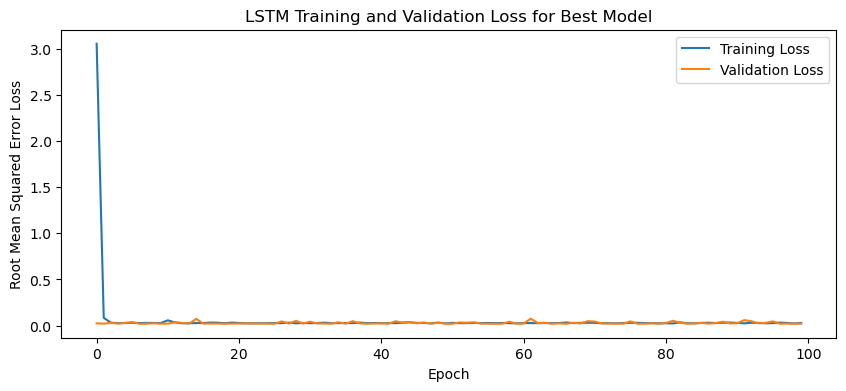

1/1 - 3s - loss: 0.0189 - 3s/epoch - 3s/step
Test Loss: 0.018870722502470016
1/1 [==============================] - 0s 61ms/step


IndexError: index 10 is out of bounds for axis 0 with size 10

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq]

    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history=best_model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

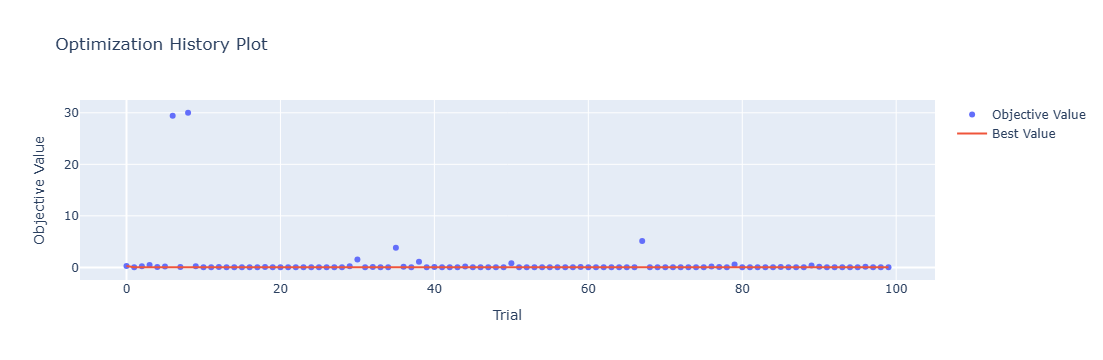

In [4]:
optuna.visualization.plot_optimization_history(study)

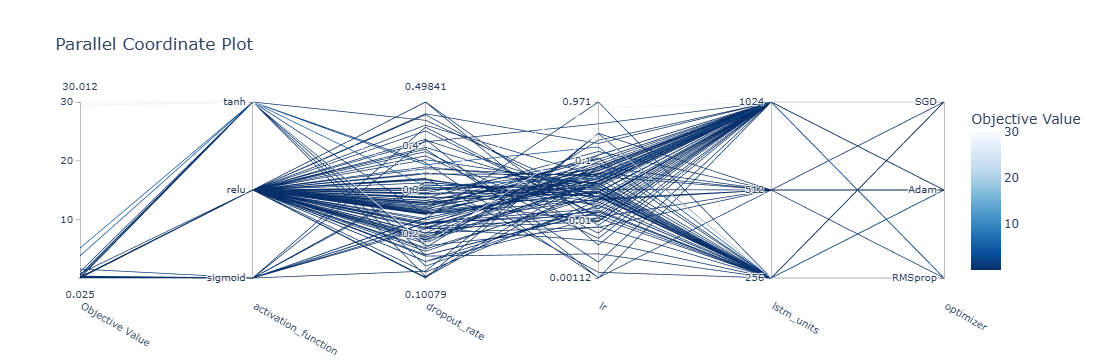

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

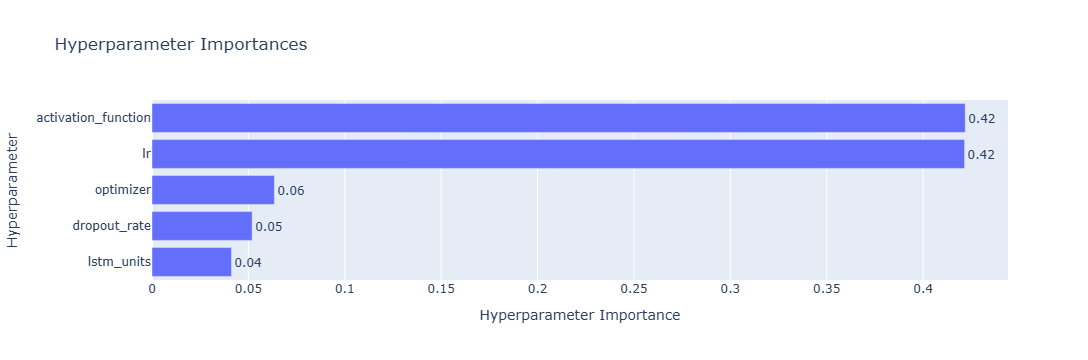

In [6]:
optuna.visualization.plot_param_importances(study)

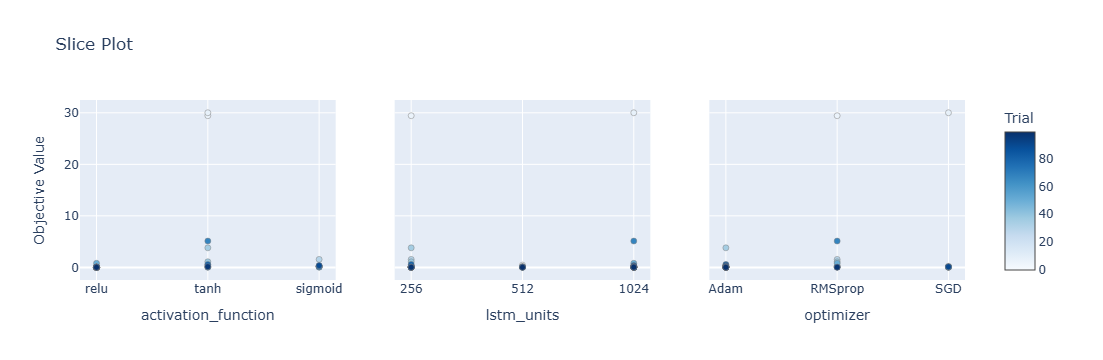

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

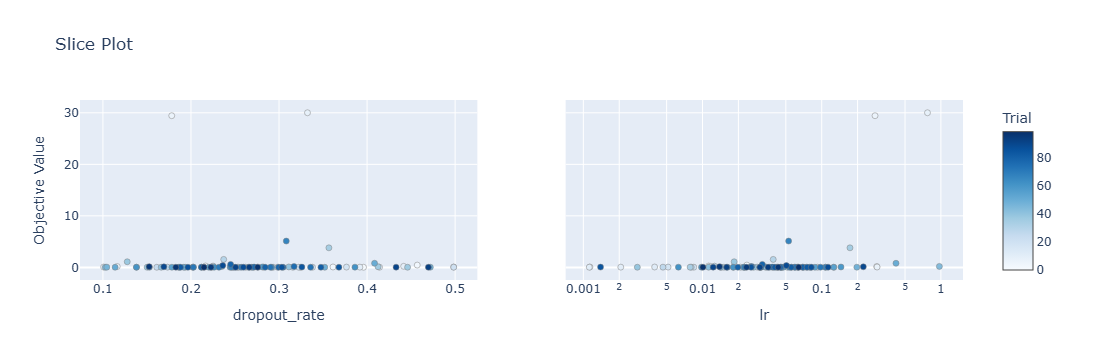

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[ 5.39  4.3   6.51 ... 13.73  8.35  9.05]
 [ 8.03  6.78  8.21 ... 17.14 11.74 12.27]
 [ 5.48  4.27  5.49 ... 13.3   9.17  8.6 ]
 ...
 [ 4.55  3.1   4.22 ... 12.8   7.91  6.65]
 [ 4.44  3.4   5.39 ... 12.34  7.74  6.78]
 [ 4.14  2.75  4.12 ... 10.6   7.07  6.41]]
Epoch 1/100
84/84 [==============================] - 27s 190ms/step - loss: 2.4167 - accuracy: 0.0000e+00 - mae: 2.4167 - rmse: 2.4167 - mape: 483.1991 - pearson: nan - val_loss: 0.0344 - val_accuracy: 0.0000e+00 - val_mae: 0.0344 - val_rmse: 0.0344 - val_mape: 6.8644 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 12s 143ms/step - loss: 0.0524 - accuracy: 0.0000e+00 - mae: 0.0524 - rmse: 0.0524 - mape: 10.8152 - pearson: nan - val_loss: 0.0352 - val_accuracy: 0.0000e+00 - val_mae: 0.0352 - val_rmse: 0.0352 - val_mape: 7.4372 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 11s 136ms/step - loss: 0.0335 - accuracy: 0.0000e+00 - mae: 0.0335 - rmse: 0.0335 - mape: 6.8076 - pearson: 

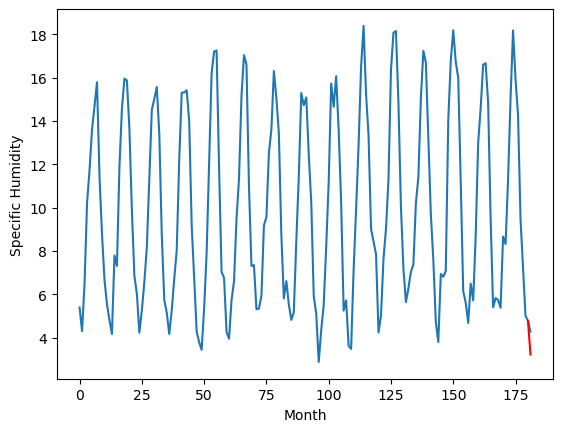

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.74		4.47		-1.27
[180, 181]
[7.05, 4.470335199832916]


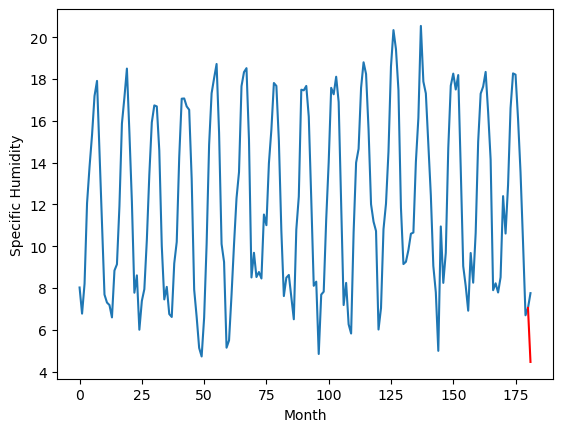

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.41		7.11		-1.30
[180, 181]
[5.06, 7.110335199832916]


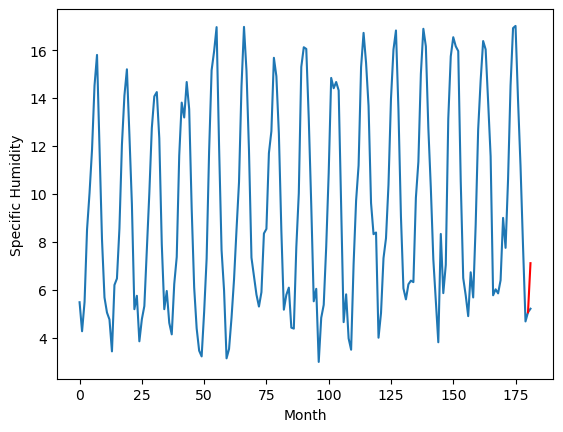

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.55		4.56		-0.99
[180, 181]
[7.05, 4.560335199832917]


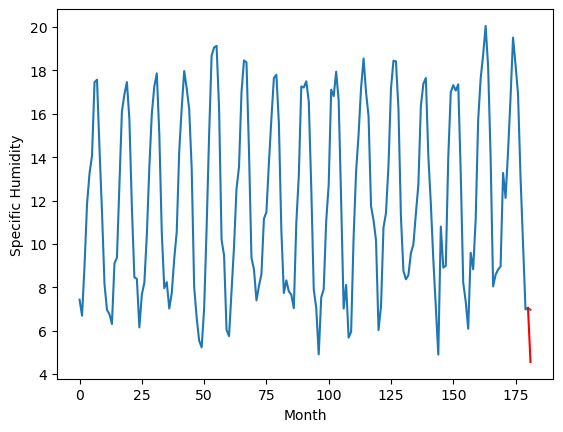

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.36		6.51		-0.85
[180, 181]
[5.2, 6.510335199832916]


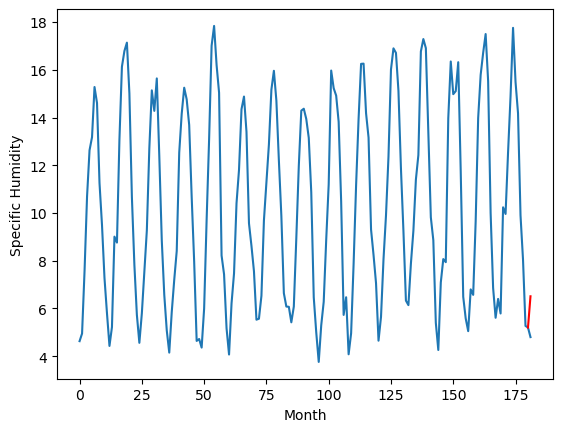

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.02		3.71		-0.31
[180, 181]
[5.16, 3.710335199832916]


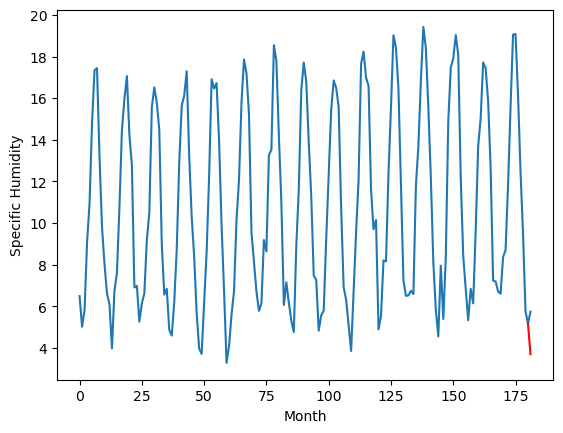

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.35		5.58		-0.77
[180, 181]
[4.05, 5.580335199832916]


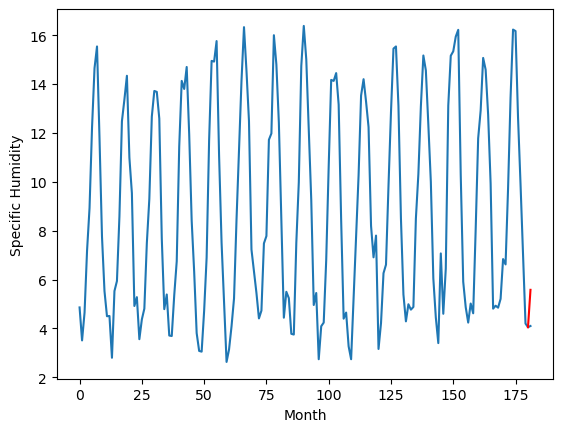

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.55		3.94		-0.61
[180, 181]
[3.64, 3.9403351998329166]


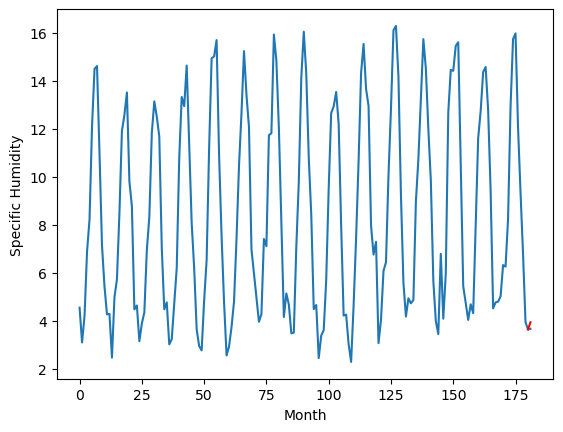

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.32		3.63		-0.69
[180, 181]
[3.46, 3.630335199832916]


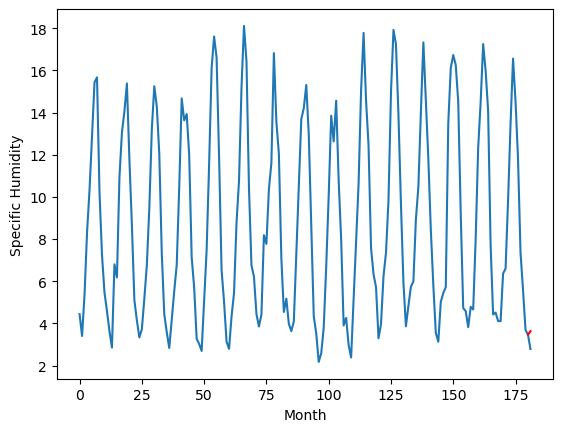

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.11		3.52		-0.59
[180, 181]
[2.93, 3.5203351998329167]


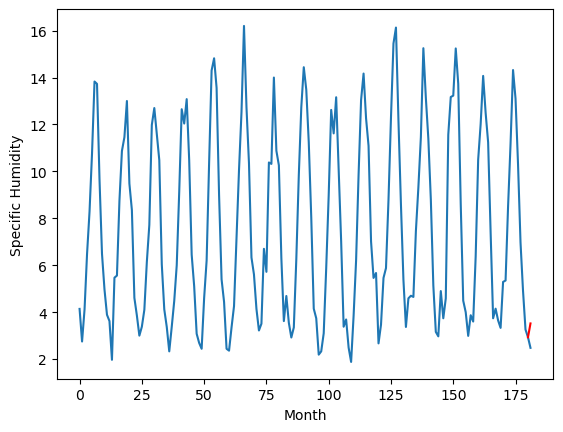

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.76		3.22		-0.54
[180, 181]
[2.74, 3.220335199832916]


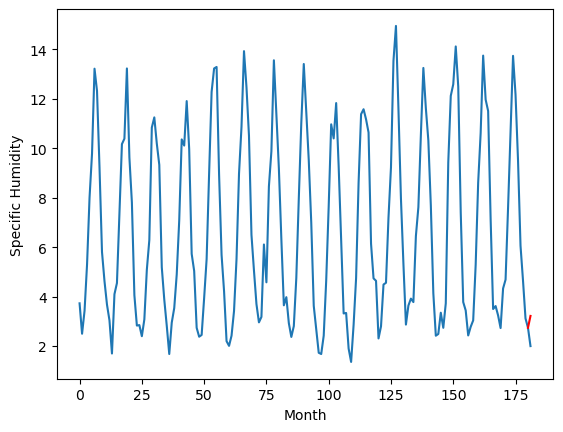

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.90   3.220335
1                 1    5.74   4.470335
2                 2    8.41   7.110335
3                 3    5.55   4.560335
4                 4    7.36   6.510335
5                 5    4.02   3.710335
6                 6    6.35   5.580335
7                 7    4.55   3.940335
8                 8    4.32   3.630335
9                 9    4.11   3.520335
10               10    3.76   3.220335


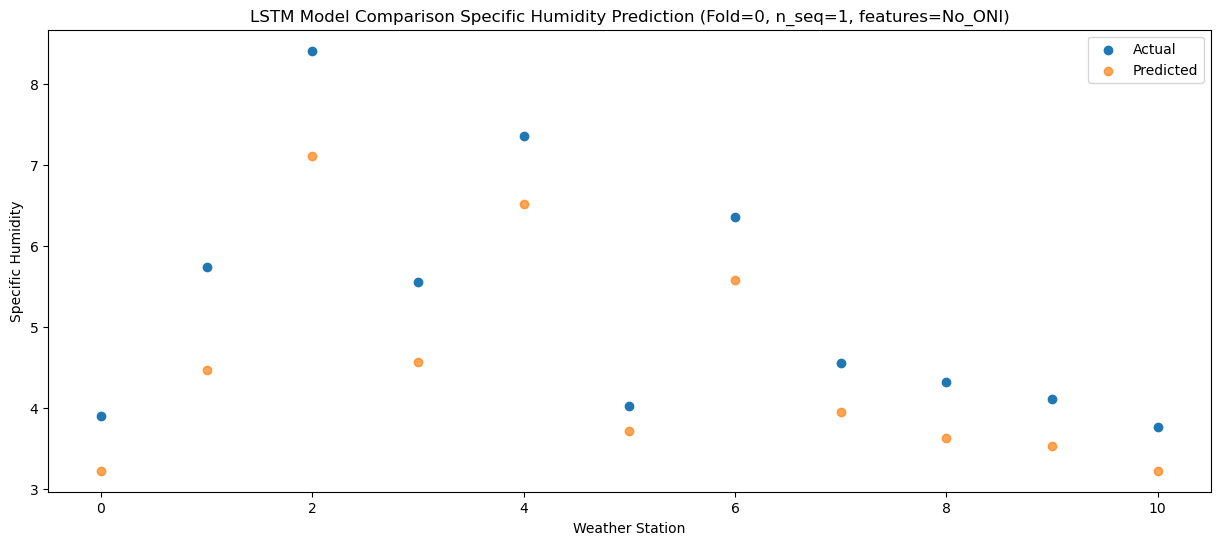

f, t:
[[3.9  5.74 8.41 5.55 7.36 4.02 6.35 4.55 4.32 4.11 3.76]]
[[3.2203352 4.4703352 7.1103352 4.5603352 6.5103352 3.7103352 5.5803352
  3.9403352 3.6303352 3.5203352 3.2203352]]
Year at t+1:
t+1 SKRMSE: 0.833341
t+1 KRMSE: 0.833341
t+1 MAE: 0.781483
t+1 SKMAPE: 0.147513
t+1 R2_SCORE: 0.684057
t+1 KMAPE: 0.147513
t+1 PEARSON: 0.978093
t+1 AVERAGE ACTUAL: 5.279091
Metrics for this Fold:
SKRMSE: 0.833341
KRMSE: 0.833341
MAE: 0.781483
SKMAPE: 0.147513
R2_SCORE: 0.684057
KMAPE: 0.147513
PEARSON: 0.978093
AVERAGE ACTUAL: 5.279091
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 1024)              12263424  
                                                                 
 dropout (Dropout)           (1, 1, 1024)              0         
                                                                 
 lstm_1 (LSTM)               (1, 1024)             

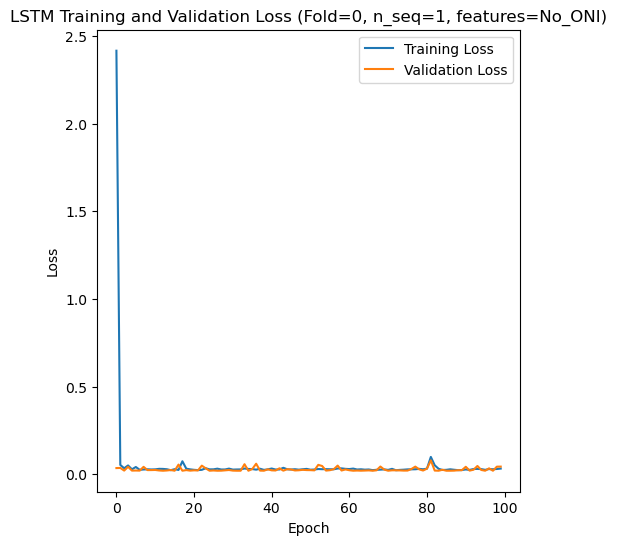

[[ 6.43  5.26  5.95 ... 15.04 10.09  9.76]
 [ 4.92  3.81  4.91 ... 12.52  8.69  7.9 ]
 [ 5.77  4.38  5.81 ... 14.28  9.78  9.52]
 ...
 [ 4.32  3.52  5.54 ... 12.    6.96  7.01]
 [ 3.07  3.12  5.08 ... 11.47  8.11  7.14]
 [ 2.37  2.06  3.5  ...  9.32  6.33  5.39]]
Epoch 1/100
84/84 [==============================] - 38s 238ms/step - loss: 1.8099 - accuracy: 0.0000e+00 - mae: 1.8099 - rmse: 1.8099 - mape: 363.4856 - pearson: nan - val_loss: 0.0329 - val_accuracy: 0.0000e+00 - val_mae: 0.0329 - val_rmse: 0.0329 - val_mape: 6.6089 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 12s 140ms/step - loss: 0.0601 - accuracy: 0.0000e+00 - mae: 0.0601 - rmse: 0.0601 - mape: 12.0730 - pearson: nan - val_loss: 0.0182 - val_accuracy: 0.0000e+00 - val_mae: 0.0182 - val_rmse: 0.0182 - val_mape: 3.6715 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 12s 147ms/step - loss: 0.0304 - accuracy: 0.0000e+00 - mae: 0.0304 - rmse: 0.0304 - mape: 6.1605 - pearson: 

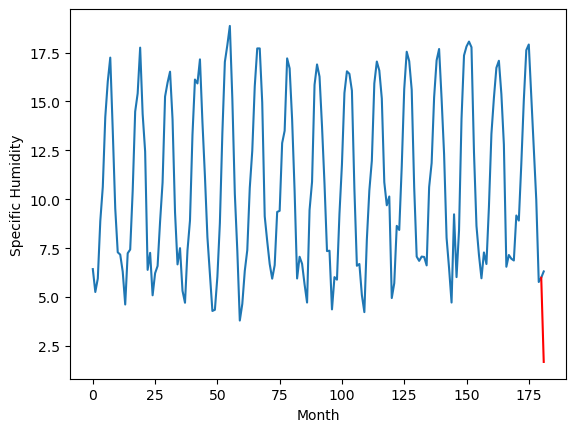

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.45		5.74		-0.71
[180, 181]
[4.15, 5.744808666706085]


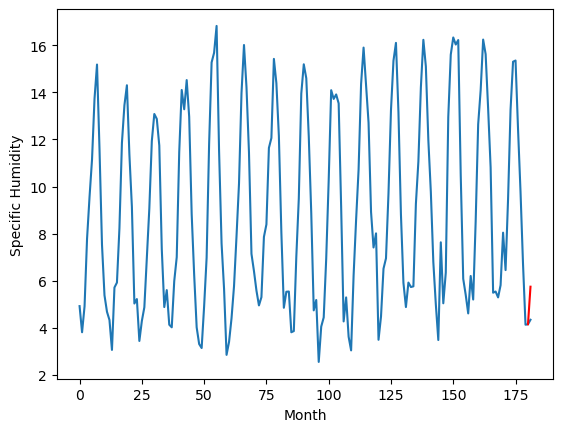

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.23		-0.84
[180, 181]
[5.12, 4.234808666706085]


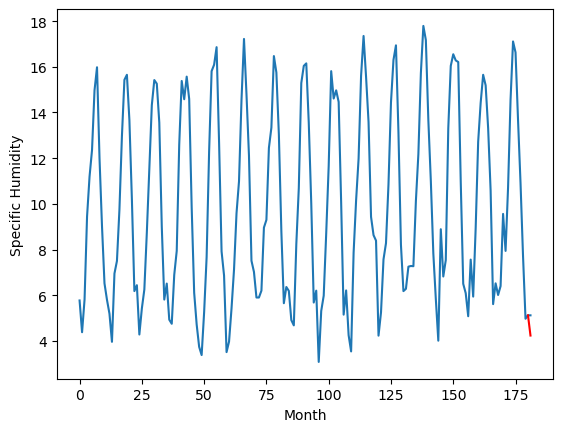

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.43		5.08		-0.35
[180, 181]
[6.35, 5.084808666706085]


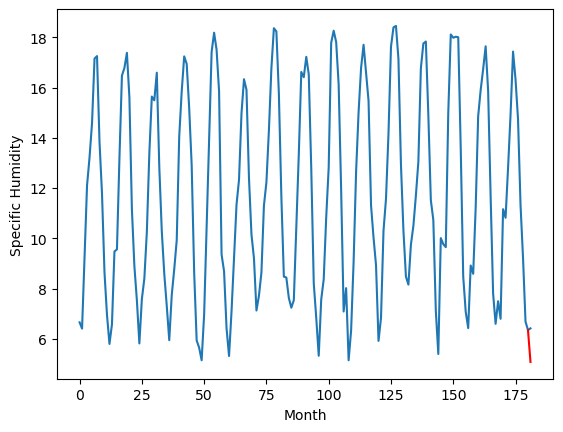

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.41		5.97		-0.44
[180, 181]
[6.08, 5.974808666706085]


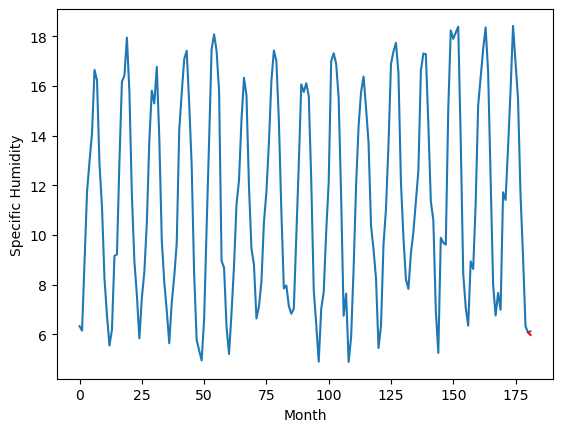

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.16		5.64		-1.52
[180, 181]
[3.92, 5.644808666706085]


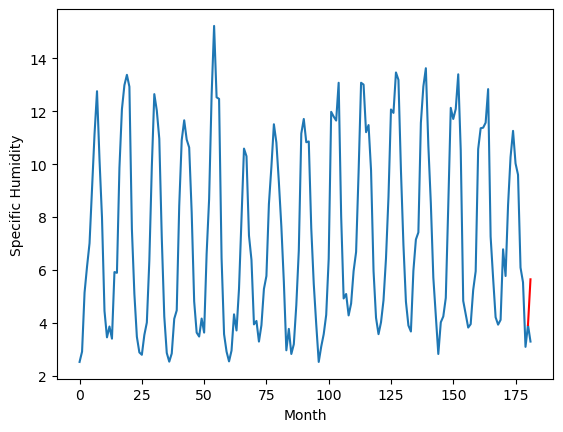

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.41		1.83		-0.58
[180, 181]
[4.16, 1.8348086667060852]


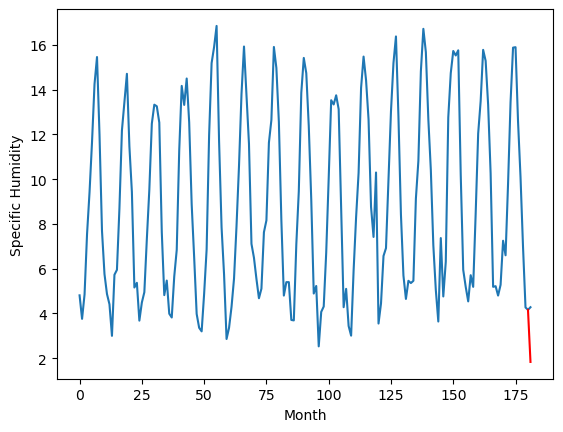

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.68		4.12		-0.56
[180, 181]
[3.84, 4.124808666706085]


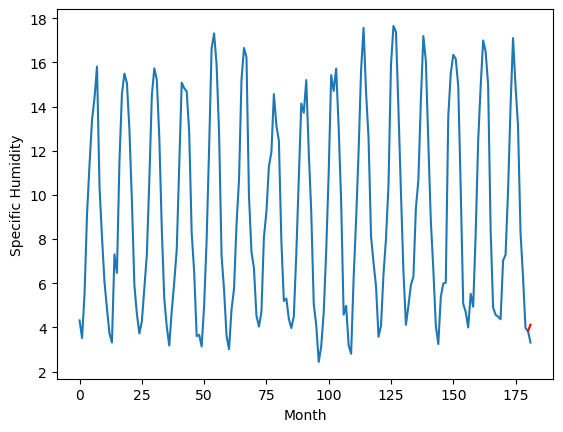

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.48		3.63		-0.85
[180, 181]
[3.73, 3.6348086667060855]


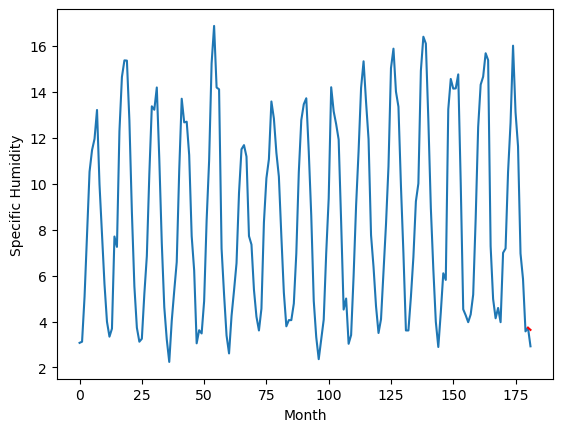

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.26		2.38		-0.88
[180, 181]
[2.83, 2.384808666706085]


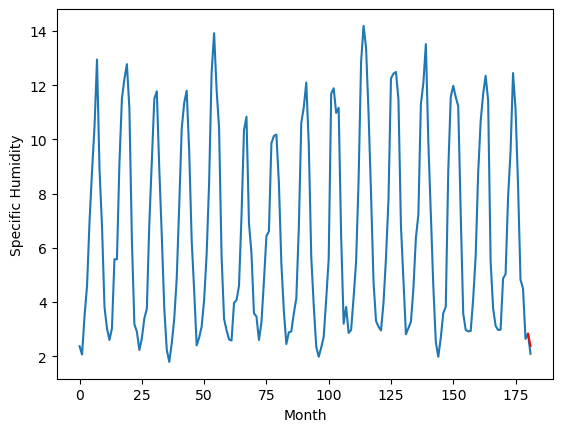

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
1.64		1.68		0.04
[180, 181]
[2.69, 1.6848086667060853]


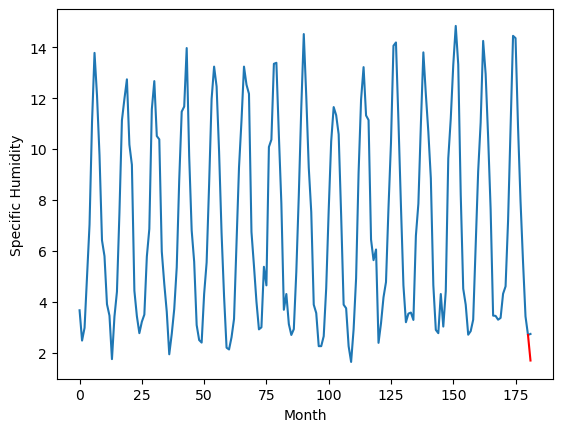

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.59   1.684809
1                 1    6.45   5.744809
2                 2    5.07   4.234809
3                 3    5.43   5.084809
4                 4    6.41   5.974809
5                 5    7.16   5.644809
6                 6    2.41   1.834809
7                 7    4.68   4.124809
8                 8    4.48   3.634809
9                 9    3.26   2.384809
10               10    1.64   1.684809


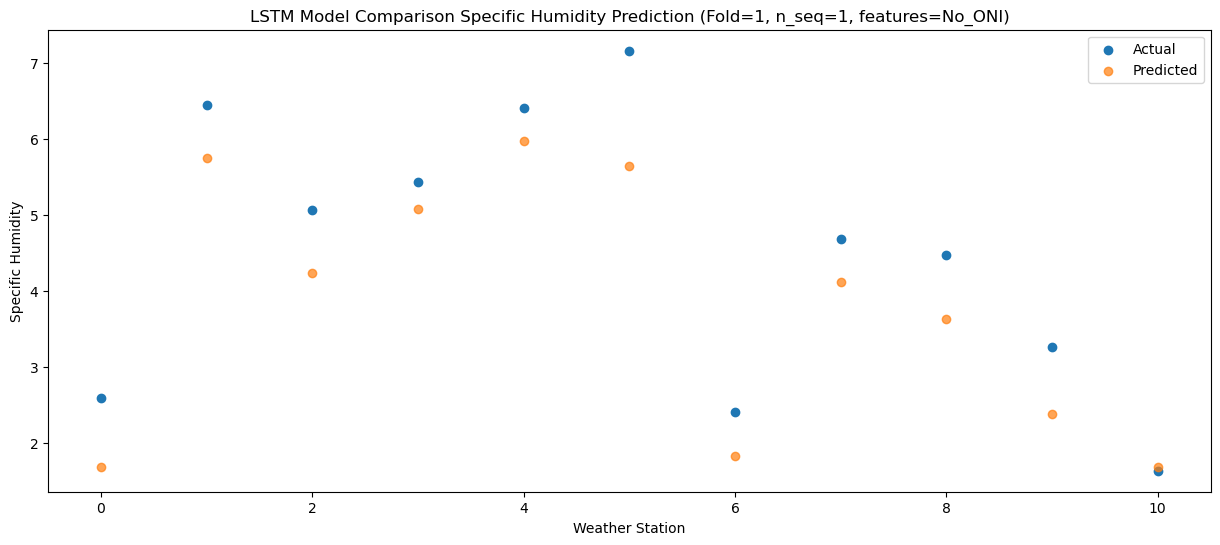

f, t:
[[2.59 6.45 5.07 5.43 6.41 7.16 2.41 4.68 4.48 3.26 1.64]]
[[1.68480867 5.74480867 4.23480867 5.08480867 5.97480867 5.64480867
  1.83480867 4.12480867 3.63480867 2.38480867 1.68480867]]
Year at t+1:
t+1 SKRMSE: 0.782767
t+1 KRMSE: 0.782767
t+1 MAE: 0.694247
t+1 SKMAPE: 0.164399
t+1 R2_SCORE: 0.798697
t+1 KMAPE: 0.164399
t+1 PEARSON: 0.956055
t+1 AVERAGE ACTUAL: 4.507273
Metrics for this Fold:
SKRMSE: 0.782767
KRMSE: 0.782767
MAE: 0.694247
SKMAPE: 0.164399
R2_SCORE: 0.798697
KMAPE: 0.164399
PEARSON: 0.956055
AVERAGE ACTUAL: 4.507273
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1, 1024)              12263424  
                                                                 
 dropout_2 (Dropout)         (1, 1, 1024)              0         
                                                                 
 lstm_3 (LSTM)               (1, 1024)

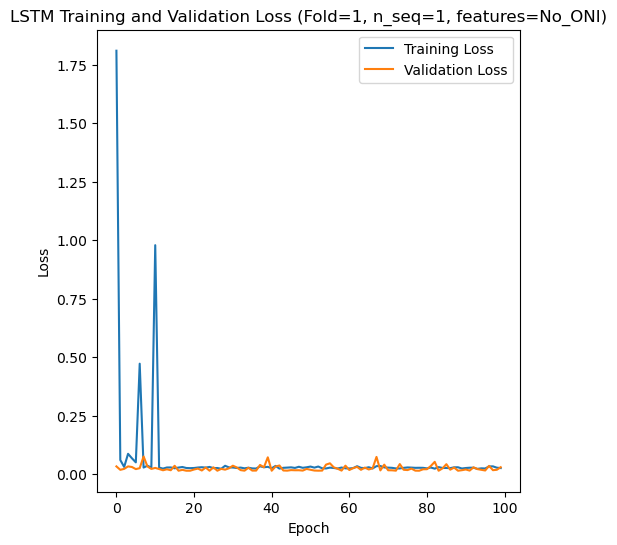

[[ 4.97  3.84  5.83 ... 12.86  8.48  8.25]
 [ 2.46  2.06  3.48 ...  9.57  6.71  5.1 ]
 [ 8.78  8.15  9.01 ... 20.36 15.38 12.95]
 ...
 [ 1.89  2.51  2.73 ...  7.42  4.53  3.35]
 [ 5.04  4.9   5.93 ... 10.09  8.19  4.88]
 [ 5.06  3.79  4.84 ... 13.58  8.96  7.8 ]]
Epoch 1/100
84/84 [==============================] - 33s 187ms/step - loss: 2.5313 - accuracy: 0.0000e+00 - mae: 2.5313 - rmse: 2.5313 - mape: 511.7205 - pearson: nan - val_loss: 0.0143 - val_accuracy: 0.0000e+00 - val_mae: 0.0143 - val_rmse: 0.0143 - val_mape: 3.0600 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 11s 132ms/step - loss: 0.0262 - accuracy: 0.0000e+00 - mae: 0.0262 - rmse: 0.0262 - mape: 5.2604 - pearson: nan - val_loss: 0.0313 - val_accuracy: 0.0000e+00 - val_mae: 0.0313 - val_rmse: 0.0313 - val_mape: 6.7158 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 12s 143ms/step - loss: 0.0278 - accuracy: 0.0000e+00 - mae: 0.0278 - rmse: 0.0278 - mape: 5.5511 - pearson: n

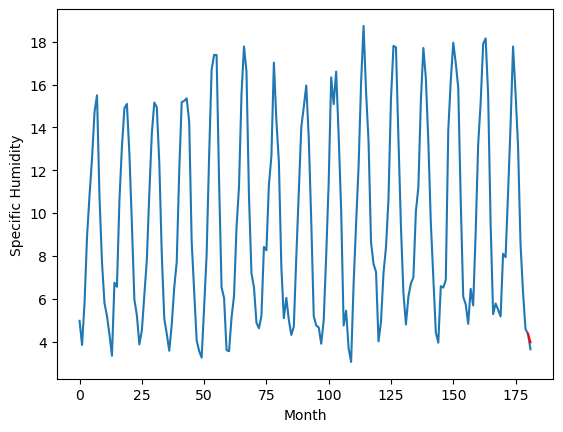

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.92		3.88		-1.04
[180, 181]
[2.82, 3.8771995019912717]


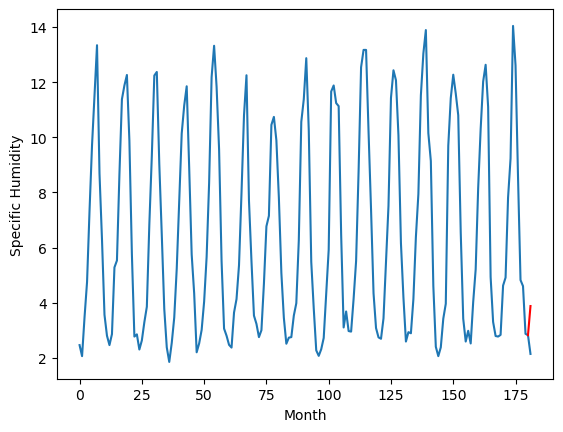

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.95		1.37		-1.58
[180, 181]
[9.16, 1.367199501991272]


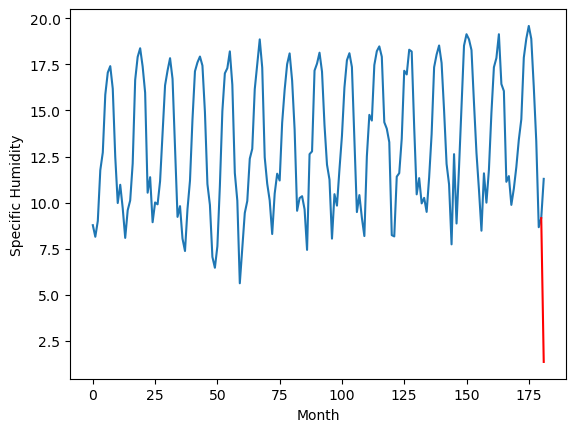

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.70		7.69		-0.01
[180, 181]
[2.44, 7.687199501991271]


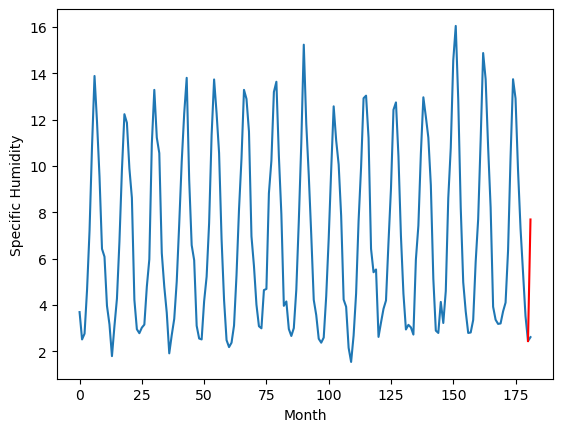

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.82		2.60		-1.22
[180, 181]
[6.65, 2.597199501991272]


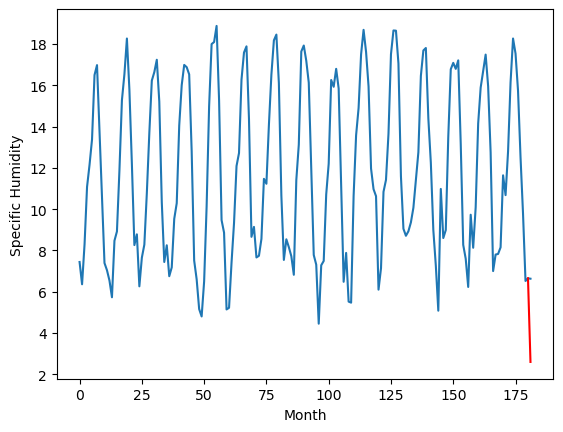

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.31		6.35		-0.96
[180, 181]
[6.19, 6.347199501991272]


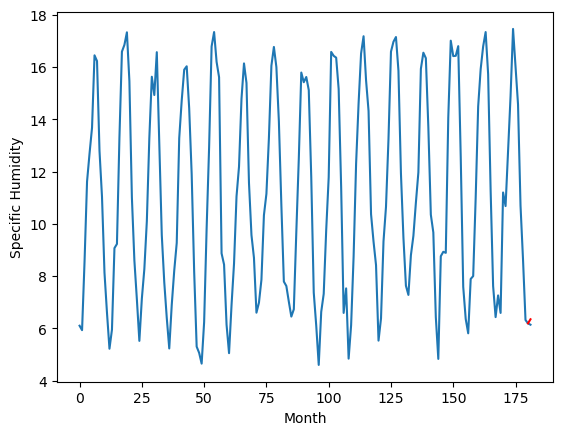

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
6.00		5.01		-0.99
[180, 181]
[4.78, 5.007199501991272]


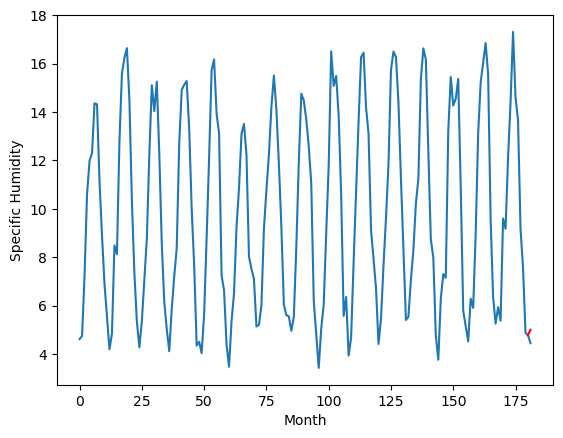

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.90		3.53		-1.37
[180, 181]
[2.61, 3.527199501991272]


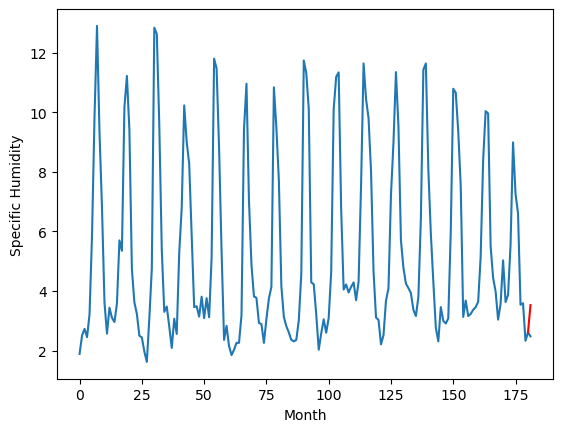

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.74		0.80		-1.94
[180, 181]
[4.6, 0.7971995019912719]


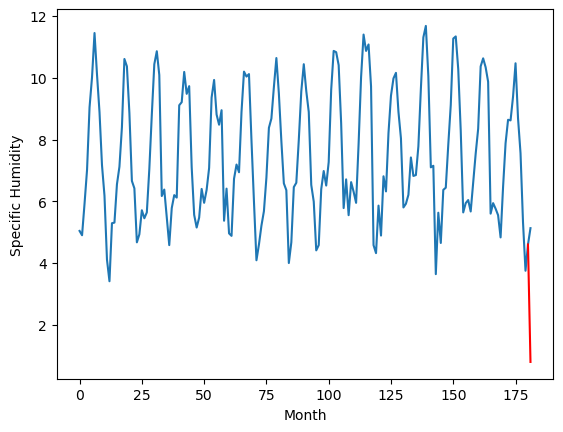

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.92		3.95		-0.97
[180, 181]
[4.27, 3.947199501991272]


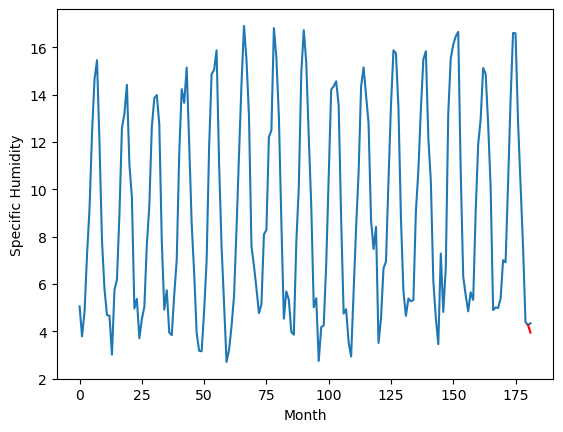

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		3.97		-1.10
[180, 181]
[3.91, 3.9671995019912716]


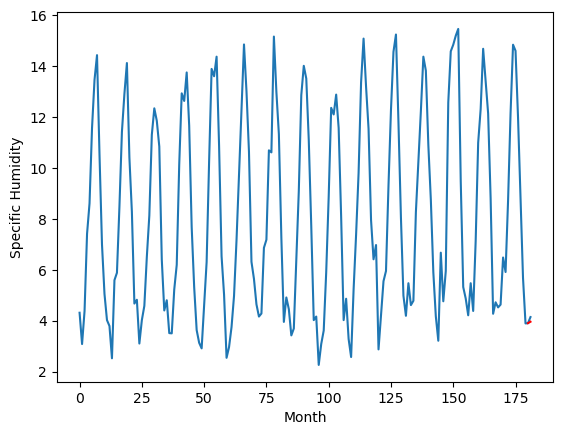

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.83     3.9672
1                 1    4.92     3.8772
2                 2    2.95     1.3672
3                 3    7.70     7.6872
4                 4    3.82     2.5972
5                 5    7.31     6.3472
6                 6    6.00     5.0072
7                 7    4.90     3.5272
8                 8    2.74     0.7972
9                 9    4.92     3.9472
10               10    5.07     3.9672


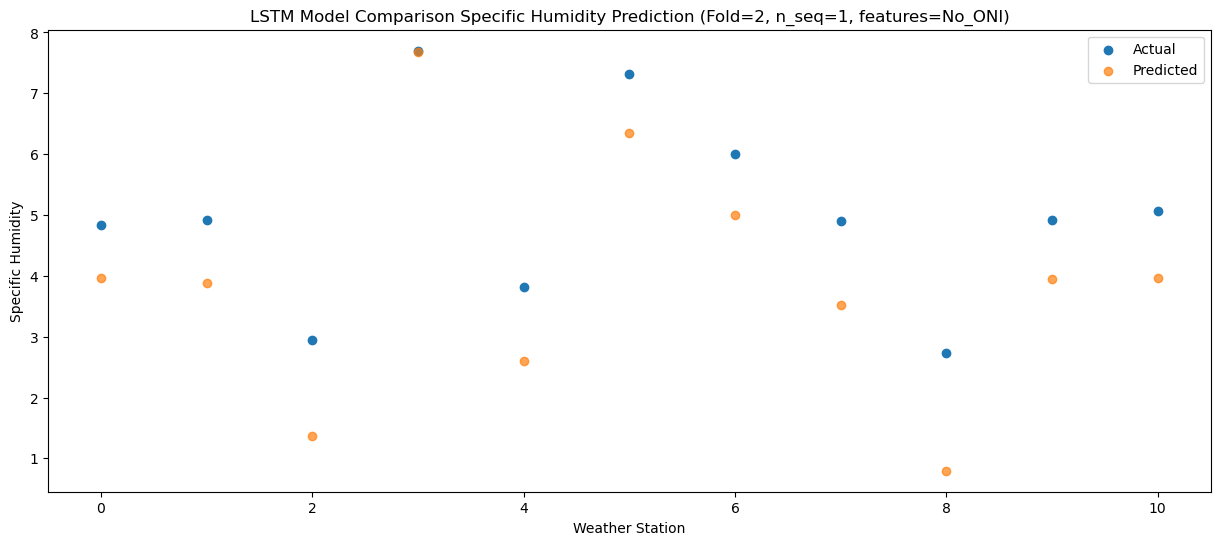

f, t:
[[4.83 4.92 2.95 7.7  3.82 7.31 6.   4.9  2.74 4.92 5.07]]
[[3.9671995 3.8771995 1.3671995 7.6871995 2.5971995 6.3471995 5.0071995
  3.5271995 0.7971995 3.9471995 3.9671995]]
Year at t+1:
t+1 SKRMSE: 1.189604
t+1 KRMSE: 1.189604
t+1 MAE: 1.097346
t+1 SKMAPE: 0.268230
t+1 R2_SCORE: 0.361571
t+1 KMAPE: 0.268230
t+1 PEARSON: 0.983358
t+1 AVERAGE ACTUAL: 5.014545
Metrics for this Fold:
SKRMSE: 1.189604
KRMSE: 1.189604
MAE: 1.097346
SKMAPE: 0.268230
R2_SCORE: 0.361571
KMAPE: 0.268230
PEARSON: 0.983358
AVERAGE ACTUAL: 5.014545
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 1, 1024)              12263424  
                                                                 
 dropout_4 (Dropout)         (1, 1, 1024)              0         
                                                                 
 lstm_5 (LSTM)               (1, 1024)           

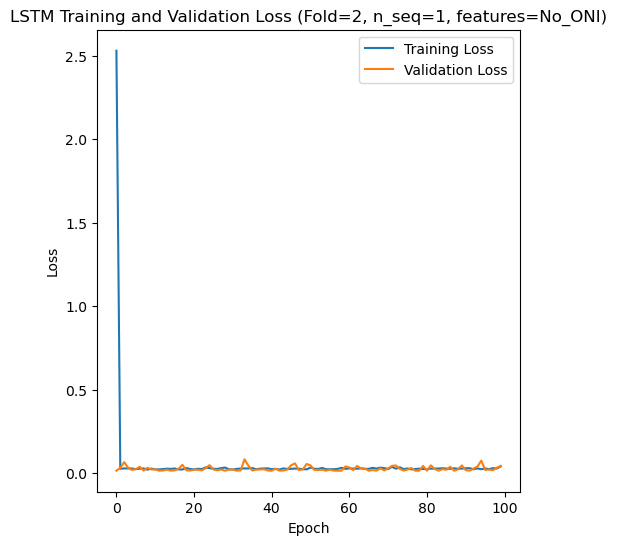

[[ 5.11  3.7   4.74 ... 13.5   8.68  7.66]
 [ 3.73  2.91  5.05 ... 11.19  6.96  6.57]
 [ 5.56  5.41  5.55 ...  8.56  7.45  5.59]
 ...
 [ 2.73  2.21  3.23 ...  5.    3.95  3.09]
 [ 5.93  5.59  5.49 ...  8.63  7.04  6.11]
 [ 3.71  2.55  2.84 ...  9.78  6.68  4.77]]
Epoch 1/100
84/84 [==============================] - 34s 219ms/step - loss: 2.5305 - accuracy: 0.0000e+00 - mae: 2.5305 - rmse: 2.5305 - mape: 514.6967 - pearson: nan - val_loss: 0.0225 - val_accuracy: 0.0000e+00 - val_mae: 0.0225 - val_rmse: 0.0225 - val_mape: 4.2735 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 12s 144ms/step - loss: 0.0298 - accuracy: 0.0000e+00 - mae: 0.0298 - rmse: 0.0298 - mape: 6.0622 - pearson: nan - val_loss: 0.0190 - val_accuracy: 0.0000e+00 - val_mae: 0.0190 - val_rmse: 0.0190 - val_mape: 3.7310 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 14s 167ms/step - loss: 0.0371 - accuracy: 0.0000e+00 - mae: 0.0371 - rmse: 0.0371 - mape: 7.5484 - pearson: n

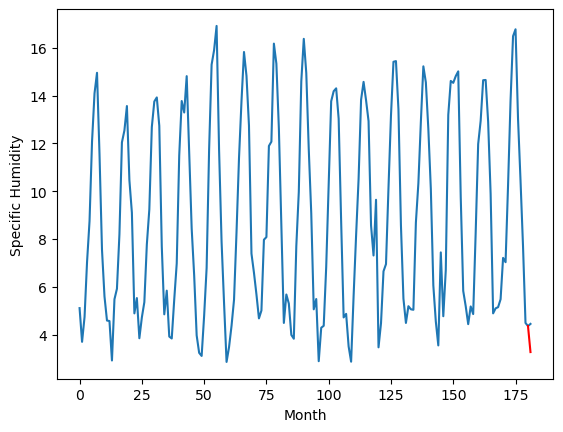

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.02		4.67		-0.35
[180, 181]
[3.43, 4.6718876516819]


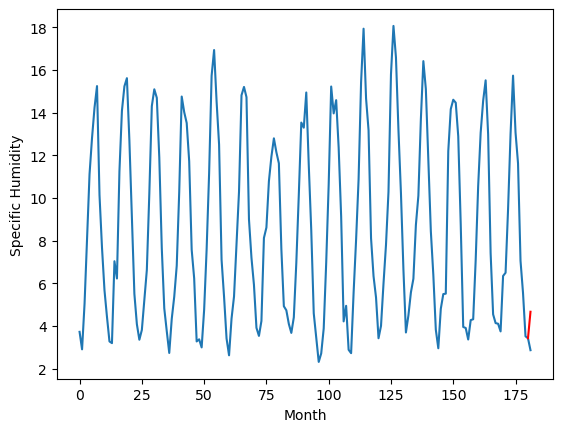

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.17		3.29		-0.88
[180, 181]
[5.43, 3.2918876516819]


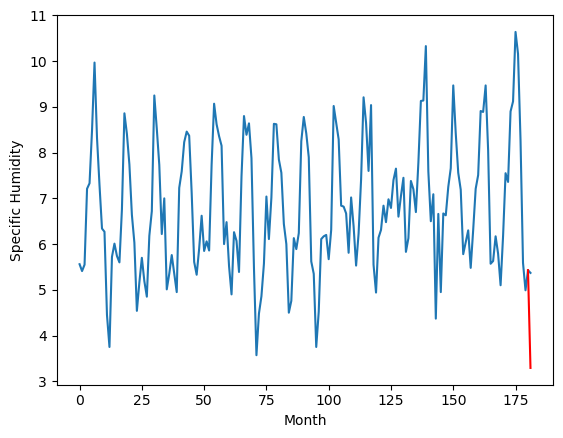

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.29		5.12		-0.17
[180, 181]
[3.21, 5.1218876516819]


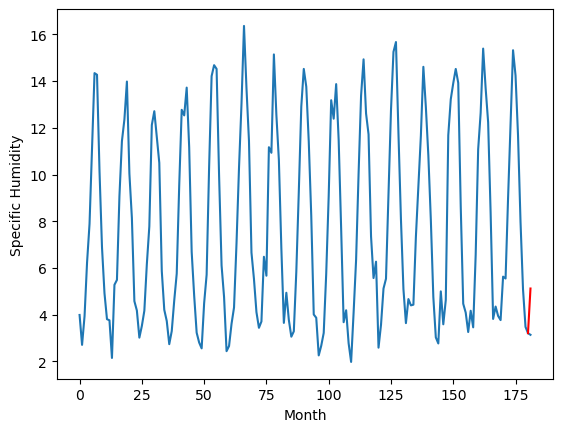

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.79		3.55		-0.24
[180, 181]
[3.04, 3.5518876516819002]


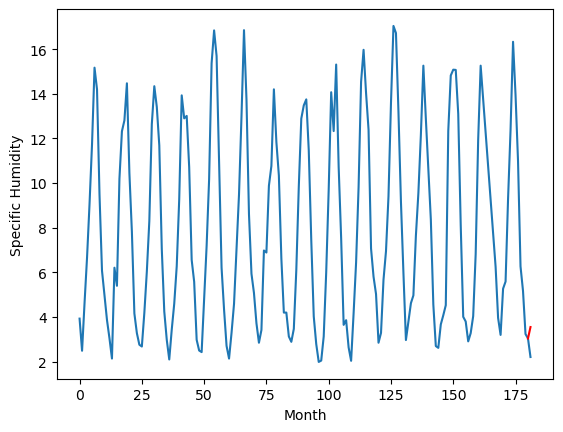

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.62		3.49		-0.13
[180, 181]
[2.91, 3.4918876516819]


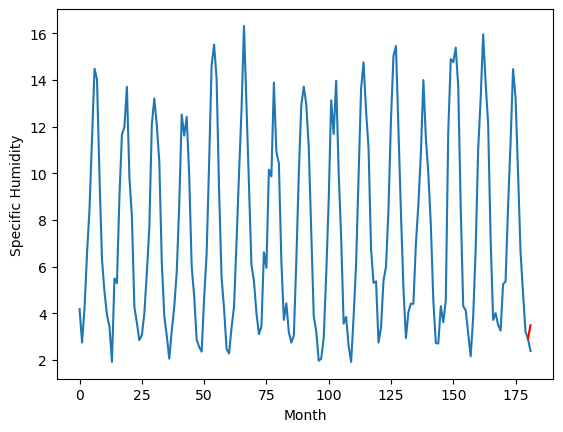

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.35		3.74		-0.61
[180, 181]
[1.6, 3.7418876516818997]


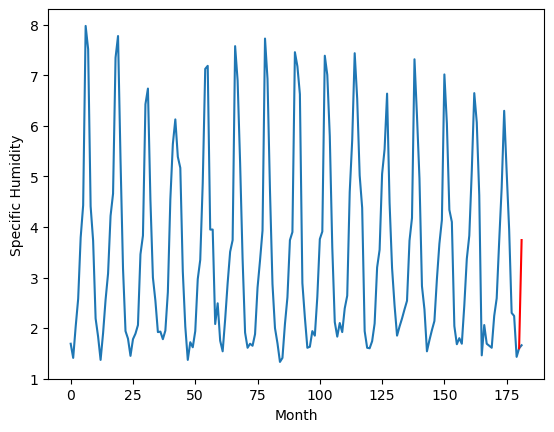

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.50		1.25		-1.25
[180, 181]
[2.86, 1.2518876516819]


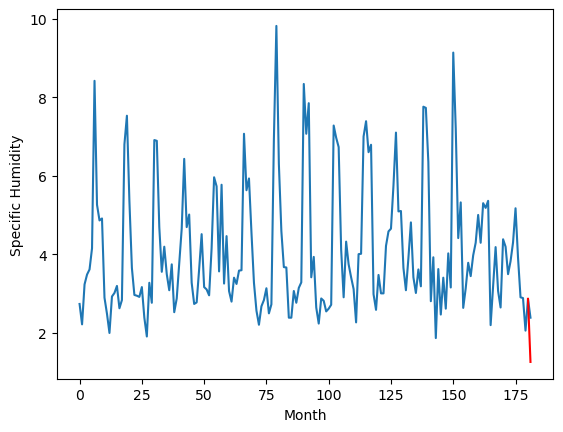

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.40		2.29		-1.11
[180, 181]
[5.65, 2.2918876516819]


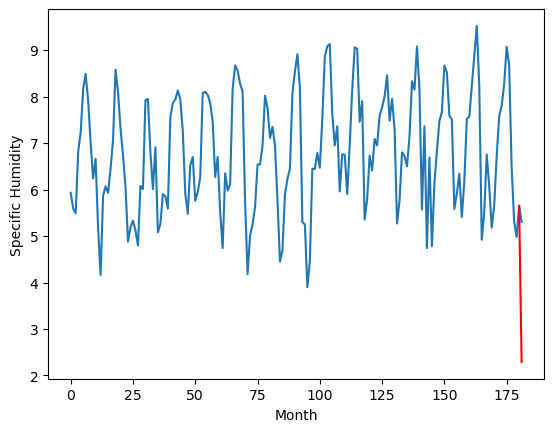

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.84		5.49		0.65
[180, 181]
[2.54, 5.4918876516819]


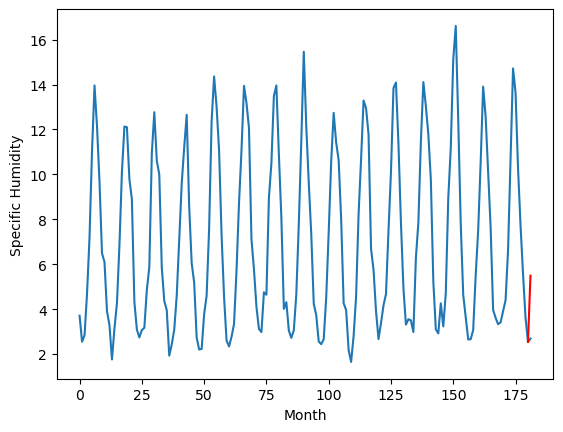

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.02		3.27		0.25
[180, 181]
[2.51, 3.2718876516819]


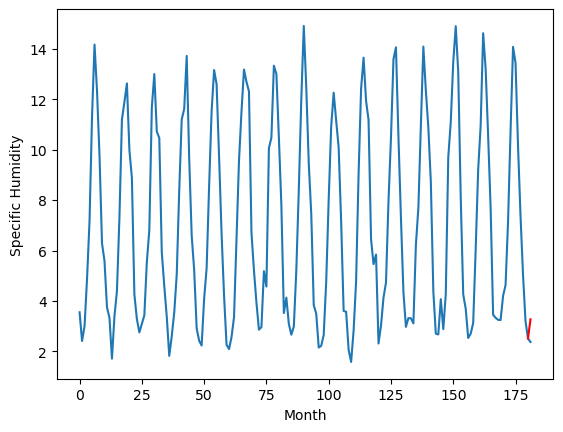

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.58   3.271888
1                 1    5.02   4.671888
2                 2    4.17   3.291888
3                 3    5.29   5.121888
4                 4    3.79   3.551888
5                 5    3.62   3.491888
6                 6    4.35   3.741888
7                 7    2.50   1.251888
8                 8    3.40   2.291888
9                 9    4.84   5.491888
10               10    3.02   3.271888


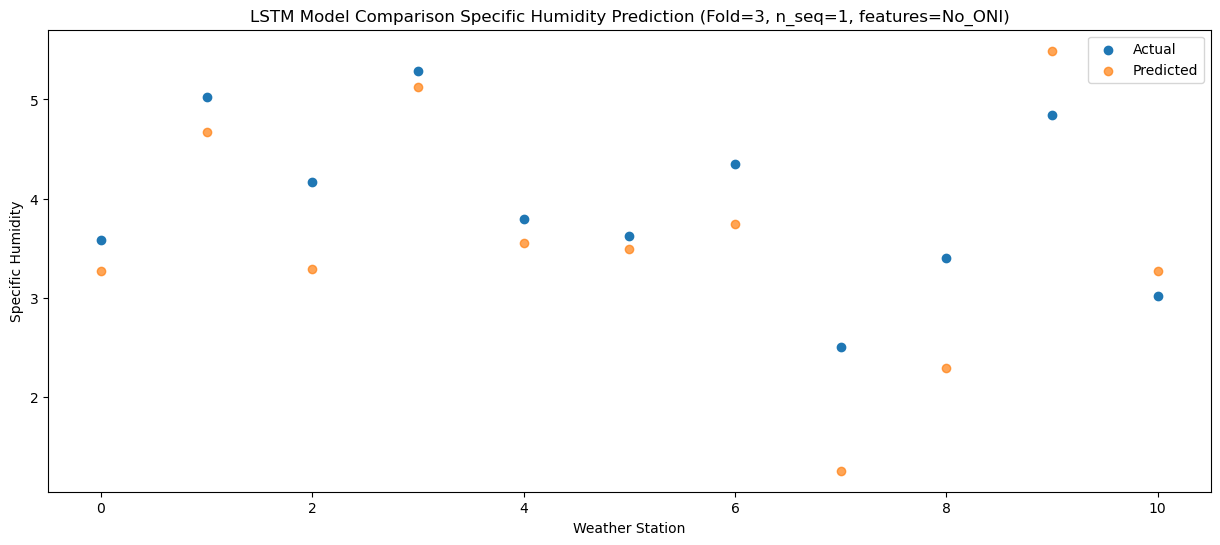

f, t:
[[3.58 5.02 4.17 5.29 3.79 3.62 4.35 2.5  3.4  4.84 3.02]]
[[3.27188765 4.67188765 3.29188765 5.12188765 3.55188765 3.49188765
  3.74188765 1.25188765 2.29188765 5.49188765 3.27188765]]
Year at t+1:
t+1 SKRMSE: 0.655915
t+1 KRMSE: 0.655915
t+1 MAE: 0.539708
t+1 SKMAPE: 0.152640
t+1 R2_SCORE: 0.367381
t+1 KMAPE: 0.152640
t+1 PEARSON: 0.817852
t+1 AVERAGE ACTUAL: 3.961818
Metrics for this Fold:
SKRMSE: 0.655915
KRMSE: 0.655915
MAE: 0.539708
SKMAPE: 0.152640
R2_SCORE: 0.367381
KMAPE: 0.152640
PEARSON: 0.817852
AVERAGE ACTUAL: 3.961818
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 1, 1024)              12263424  
                                                                 
 dropout_6 (Dropout)         (1, 1, 1024)              0         
                                                                 
 lstm_7 (LSTM)               (1, 1024)

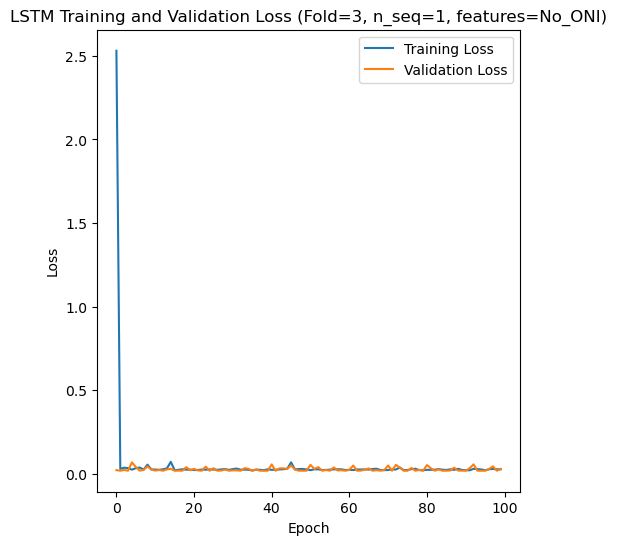

[[ 3.4   2.19  4.28 ... 10.54  6.41  5.39]
 [ 7.94  7.22  7.86 ... 18.27 13.85 11.85]
 [ 5.92  4.91  6.84 ... 14.38  9.59 10.48]
 ...
 [ 3.92  3.    4.93 ... 11.51  7.19  6.46]
 [ 3.98  2.61  4.   ... 10.23  6.65  5.8 ]
 [ 3.84  2.35  4.25 ... 10.6   6.5   5.9 ]]
Epoch 1/100
84/84 [==============================] - 42s 236ms/step - loss: 2.4416 - accuracy: 0.0000e+00 - mae: 2.4416 - rmse: 2.4416 - mape: 491.4973 - pearson: nan - val_loss: 0.0750 - val_accuracy: 0.0000e+00 - val_mae: 0.0750 - val_rmse: 0.0750 - val_mape: 15.3249 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 15s 173ms/step - loss: 0.0350 - accuracy: 0.0000e+00 - mae: 0.0350 - rmse: 0.0350 - mape: 7.0783 - pearson: nan - val_loss: 0.0326 - val_accuracy: 0.0000e+00 - val_mae: 0.0326 - val_rmse: 0.0326 - val_mape: 6.3888 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 14s 172ms/step - loss: 0.0235 - accuracy: 0.0000e+00 - mae: 0.0235 - rmse: 0.0235 - mape: 4.7765 - pearson: 

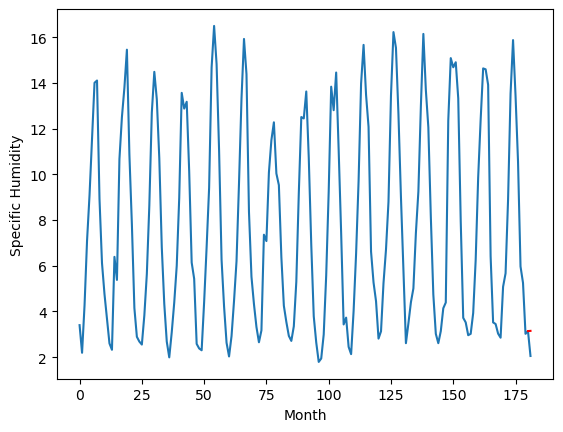

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.75		2.71		-1.04
[180, 181]
[7.79, 2.709324562549591]


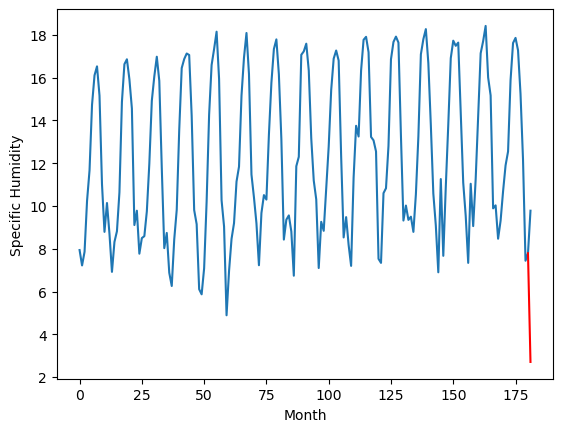

Weather Station 3:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.83		7.25		-0.58
[180, 181]
[5.03, 7.2493245625495915]


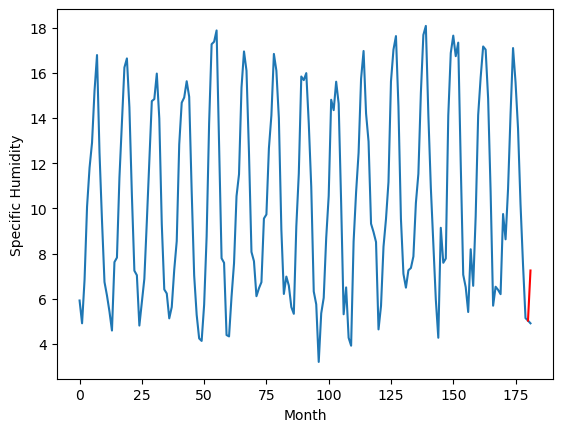

Weather Station 4:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.81		5.23		-0.58
[180, 181]
[4.41, 5.229324562549591]


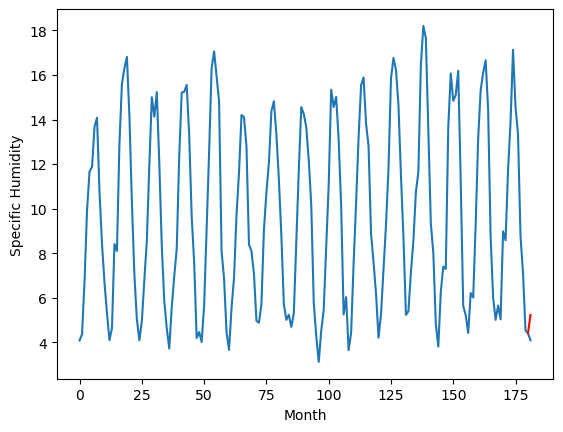

Weather Station 5:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.04		3.39		-0.65
[180, 181]
[4.29, 3.389324562549591]


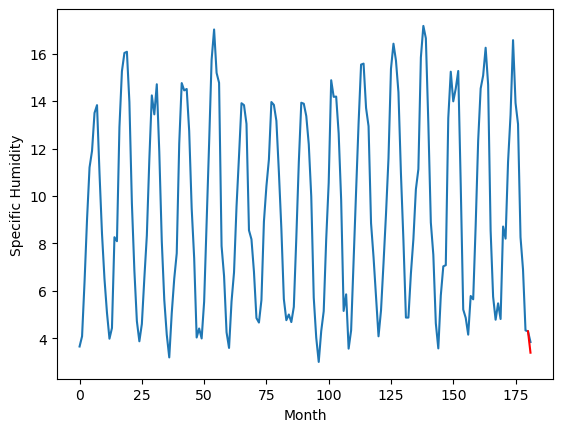

Weather Station 6:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
4.35		2.96		-1.39
[180, 181]
[3.47, 2.959324562549591]


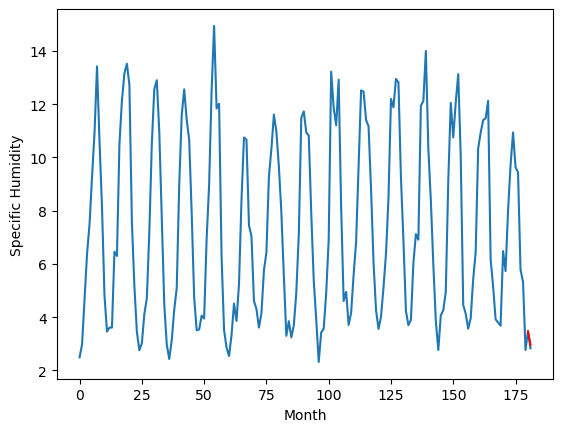

Weather Station 7:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
2.37		1.80		-0.57
[180, 181]
[4.52, 1.7993245625495913]


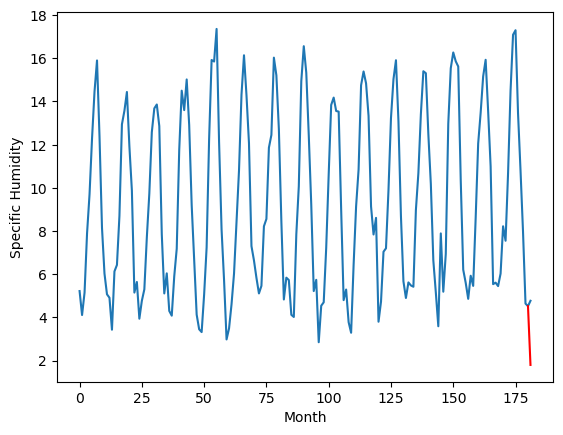

Weather Station 8:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
5.07		4.53		-0.54
[180, 181]
[3.4, 4.529324562549591]


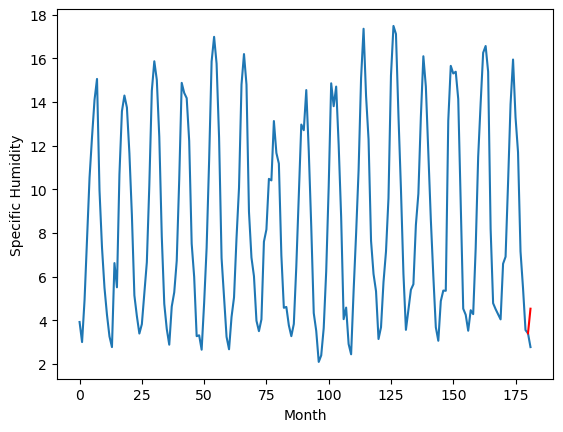

Weather Station 9:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.57		3.23		-0.34
[180, 181]
[2.82, 3.229324562549591]


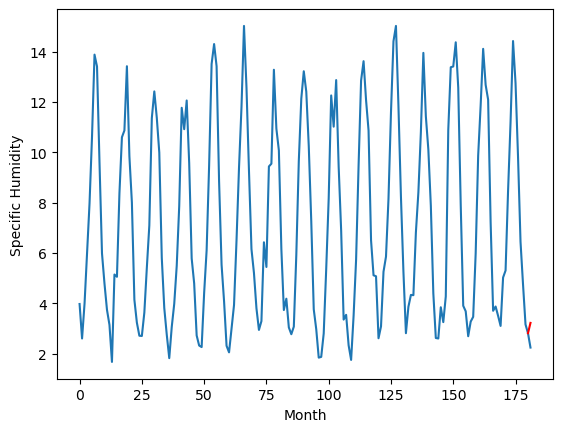

Weather Station 10:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.66		3.29		-0.37
[180, 181]
[2.86, 3.289324562549591]


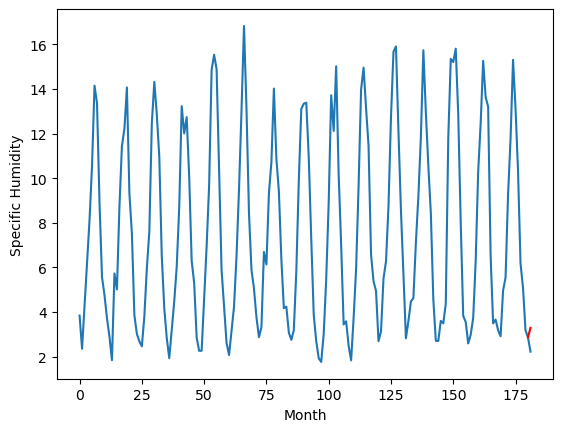

Weather Station 11:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
3.46		3.15		-0.31
[180, 181]
[2.61, 3.149324562549591]


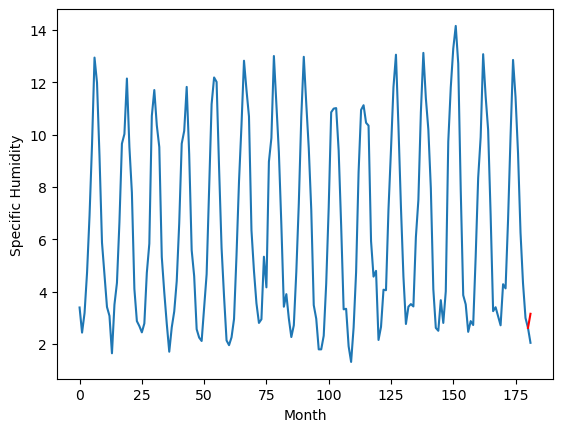

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    3.96   3.149325
1                 1    3.75   2.709325
2                 2    7.83   7.249325
3                 3    5.81   5.229325
4                 4    4.04   3.389325
5                 5    4.35   2.959325
6                 6    2.37   1.799325
7                 7    5.07   4.529325
8                 8    3.57   3.229325
9                 9    3.66   3.289325
10               10    3.46   3.149325


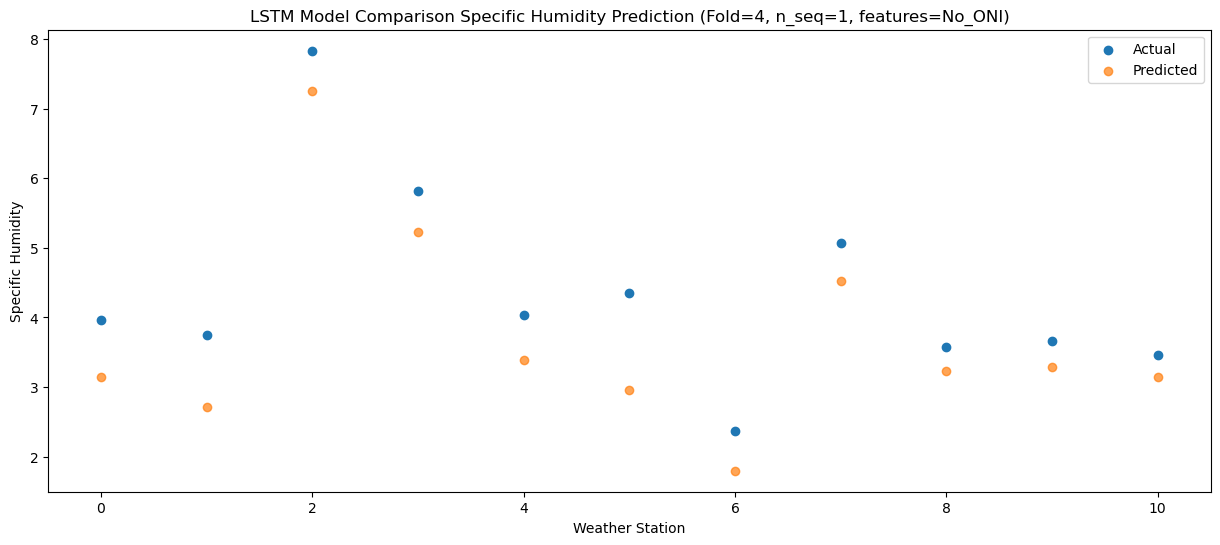

f, t:
[[3.96 3.75 7.83 5.81 4.04 4.35 2.37 5.07 3.57 3.66 3.46]]
[[3.14932456 2.70932456 7.24932456 5.22932456 3.38932456 2.95932456
  1.79932456 4.52932456 3.22932456 3.28932456 3.14932456]]
Year at t+1:
t+1 SKRMSE: 0.722364
t+1 KRMSE: 0.722364
t+1 MAE: 0.653403
t+1 SKMAPE: 0.161001
t+1 R2_SCORE: 0.728809
t+1 KMAPE: 0.161001
t+1 PEARSON: 0.952325
t+1 AVERAGE ACTUAL: 4.351818
Metrics for this Fold:
SKRMSE: 0.722364
KRMSE: 0.722364
MAE: 0.653403
SKMAPE: 0.161001
R2_SCORE: 0.728809
KMAPE: 0.161001
PEARSON: 0.952325
AVERAGE ACTUAL: 4.351818
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (1, 1, 1024)              12263424  
                                                                 
 dropout_8 (Dropout)         (1, 1, 1024)              0         
                                                                 
 lstm_9 (LSTM)               (1, 1024)

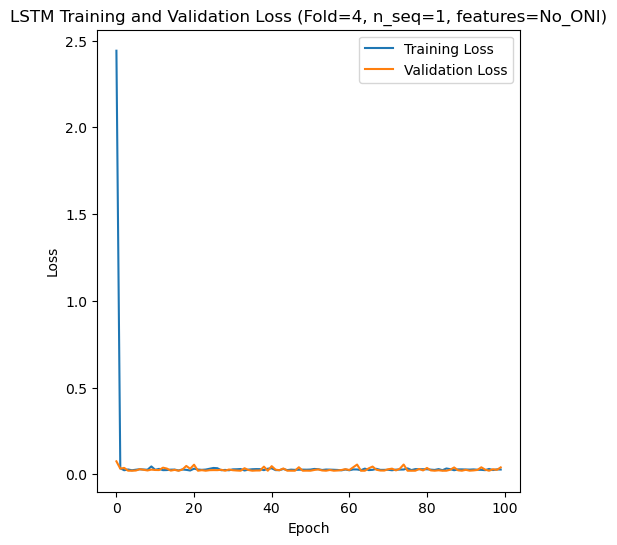

[[0.8333413465638875], [0.7827668073801882], [1.1896035345185858], [0.6559151612655282], [0.7223638154232453]]
[[array(0.83334135)], [array(0.78276681)], [array(1.18960353)], [array(0.65591516)], [array(0.72236382)]]
[[0.7814829819852656], [0.6942474545132031], [1.0973459525541824], [0.539707858020609], [0.6534027101776817]]
[[0.1475129271962238], [0.16439866461260857], [0.2682295243586617], [0.15263951899188558], [0.16100149720192736]]
[[0.6840565514388728], [0.7986966285351775], [0.36157144251019513], [0.3673812037646126], [0.7288092866896476]]
[[array(0.14751293)], [array(0.16439866)], [array(0.26822952)], [array(0.15263952)], [array(0.1610015)]]
[[array(0.97809323)], [array(0.95605519)], [array(0.98335797)], [array(0.81785213)], [array(0.95232505)]]
[3.9  5.74 8.41 5.55 7.36 4.02 6.35 4.55 4.32 4.11 3.76 2.59 6.45 5.07
 5.43 6.41 7.16 2.41 4.68 4.48 3.26 1.64 4.83 4.92 2.95 7.7  3.82 7.31
 6.   4.9  2.74 4.92 5.07 3.58 5.02 4.17 5.29 3.79 3.62 4.35 2.5  3.4
 4.84 3.02 3.96 3.75 7.8

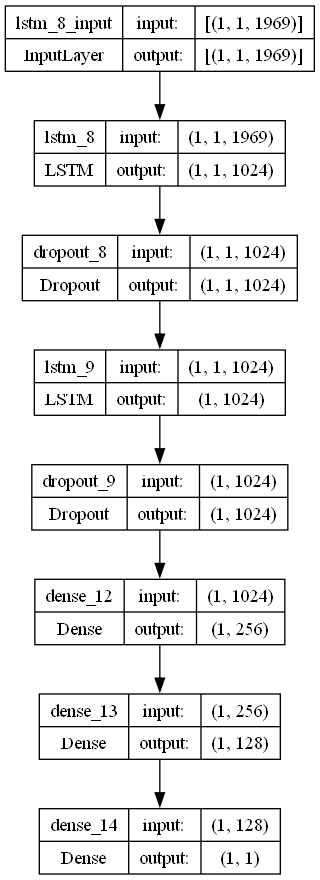

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.039132699815151946
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 1024
    dropout_rate = 0.30465317720917506

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S1_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)